In [1]:
import keras
from keras.models import Sequential
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib 

Using TensorFlow backend.
C:\Users\HH TRADERS\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
train = pd.read_csv('../data/train.csv')
train.sort_values(by=['class', 'image'])
train.tail()

,image,class
13017,winKen_wave_u_cm_np1_ri_bad_1_frame0.jpg,wave
13018,winKen_wave_u_cm_np1_ri_bad_1_frame1.jpg,wave
13019,winKen_wave_u_cm_np1_ri_bad_1_frame2.jpg,wave
13020,winKen_wave_u_cm_np1_ri_bad_1_frame3.jpg,wave
13021,winKen_wave_u_cm_np1_ri_bad_1_frame4.jpg,wave


In [3]:
# creating an empty list
train_image = []

# for loop to read and store frames
for i in tqdm(range(train.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img('../data/train_frame/'+train['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    train_image.append(img)

100%|██████████| 13022/13022 [01:33<00:00, 139.86it/s]


In [4]:
# converting the list to numpy array
X_train = np.array(train_image,np.float16)

# shape of the array
X_train.shape

(13022, 224, 224, 3)

In [5]:
val = pd.read_csv('../data/val.csv')
val.sort_values(by=['class', 'image'])
val.tail()

,image,class
5504,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
5505,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
5506,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
5507,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
5508,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave


In [6]:
# creating an empty list
val_image = []

# for loop to read and store frames
for i in tqdm(range(val.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img('../data/val_frame/'+val['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    val_image.append(img)

100%|██████████| 5509/5509 [00:51<00:00, 106.61it/s]


In [7]:
# converting the list to numpy array
X_test = np.array(val_image,np.float16)

# shape of the array
X_test.shape

(5509, 224, 224, 3)

In [8]:
# separating the target
y_train = train['class']
y_test = val['class']
print(train.nunique())
print(val.nunique())

image    13022
class       51
dtype: int64
image    5509
class      51
dtype: int64


In [9]:
# creating dummies of target variable for train and validation set
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
print(y_train.shape)
print(y_test.shape)

(13022, 51)
(5509, 51)


In [10]:
base_model = InceptionV3(include_top=False, weights='imagenet')

In [11]:
print(base_model.output_shape)

(None, None, None, 2048)


In [12]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

__________________________________________________________________________________________________
mixed0 (Concatenate)            (None, None, None, 2 0           activation_6[0][0]               
                                                                 activation_8[0][0]               
                                                                 activation_11[0][0]              
                                                                 activation_12[0][0]              
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, None, None, 6 16384       mixed0[0][0]                     
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, None, None, 6 192         conv2d_16[0][0]                  
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, None, None, 6 192         conv2d_20[0][0]                  
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, None, None, 6 192         conv2d_22[0][0]                  
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, None, None, 9 288         conv2d_25[0][0]                  
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, None, None, 6 192         conv2d_26[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, None, None, 6 0           batch_normalization_20[0][0]     
__________

batch_normalization_38 (BatchNo (None, None, None, 1 384         conv2d_38[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, None, None, 1 0           batch_normalization_33[0][0]     
__________________________________________________________________________________________________
activation_38 (Activation)      (None, None, None, 1 0           batch_normalization_38[0][0]     
__________________________________________________________________________________________________
average_pooling2d_4 (AveragePoo (None, None, None, 7 0           mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, None, None, 1 147456      mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_34 

__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, None, None, 1 576         conv2d_41[0][0]                  
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, None, None, 1 576         conv2d_44[0][0]                  
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, None, None, 1 576         conv2d_49[0][0]                  
__________________________________________________________________________________________________
batch_normalization_50 (BatchNo (None, None, None, 1 576         conv2d_50[0][0]                  
__________________________________________________________________________________________________
activation_41 (Activation)      (None, None, None, 1 0           batch_normalization_41[0][0]     
__________

activation_60 (Activation)      (None, None, None, 1 0           batch_normalization_60[0][0]     
__________________________________________________________________________________________________
mixed6 (Concatenate)            (None, None, None, 7 0           activation_51[0][0]              
                                                                 activation_54[0][0]              
                                                                 activation_59[0][0]              
                                                                 activation_60[0][0]              
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, None, None, 1 147456      mixed6[0][0]                     
__________________________________________________________________________________________________
batch_normalization_65 (BatchNo (None, None, None, 1 576         conv2d_65[0][0]                  
__________

batch_normalization_74 (BatchNo (None, None, None, 1 576         conv2d_74[0][0]                  
__________________________________________________________________________________________________
activation_74 (Activation)      (None, None, None, 1 0           batch_normalization_74[0][0]     
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, None, None, 1 147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (None, None, None, 1 258048      activation_74[0][0]              
__________________________________________________________________________________________________
batch_normalization_71 (BatchNo (None, None, None, 1 576         conv2d_71[0][0]                  
__________________________________________________________________________________________________
batch_norm

activation_84 (Activation)      (None, None, None, 3 0           batch_normalization_84[0][0]     
__________________________________________________________________________________________________
batch_normalization_85 (BatchNo (None, None, None, 1 576         conv2d_85[0][0]                  
__________________________________________________________________________________________________
activation_77 (Activation)      (None, None, None, 3 0           batch_normalization_77[0][0]     
__________________________________________________________________________________________________
mixed9_0 (Concatenate)          (None, None, None, 7 0           activation_79[0][0]              
                                                                 activation_80[0][0]              
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, None, None, 7 0           activation_83[0][0]              
          

                                                                 mixed9_1[0][0]                   
                                                                 concatenate_2[0][0]              
                                                                 activation_94[0][0]              
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
__________________________________________________________________________________________________


In [13]:
base_model.get_config()

{'name': 'inception_v3',
 'layers': [{'name': 'input_1',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, None, None, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_1'},
   'inbound_nodes': []},
  {'name': 'conv2d_1',
   'class_name': 'Conv2D',
   'config': {'name': 'conv2d_1',
    'trainable': True,
    'dtype': 'float32',
    'filters': 32,
    'kernel_size': (3, 3),
    'strides': (2, 2),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'linear',
    'use_bias': False,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'inbound_nodes': [[['input_

In [14]:
t1=datetime.datetime.now()
print(t1)
# extracting features for training frames
X_train = base_model.predict(X_train)
print(X_train.shape)
t2=datetime.datetime.now()
print(t2)

2020-03-19 01:33:52.296285
(13022, 5, 5, 2048)
2020-03-19 02:09:43.712907


In [15]:
t3=datetime.datetime.now()
print(t3)
# extracting features for validation frames
X_test = base_model.predict(X_test)
print(X_test.shape)
t4=datetime.datetime.now()
print(t4)

2020-03-19 02:09:43.737841
(5509, 5, 5, 2048)
2020-03-19 02:22:42.079422


In [16]:
# reshaping the training as well as validation frames in single dimension
X_train = X_train.reshape(13022, 5*5*2048)
X_test = X_test.reshape(5509, 5*5*2048)

In [17]:
# normalizing the pixel values
max = X_train.max()
X_train = X_train/max
X_test = X_test/max

In [18]:
# Save the model as a pickle in a file 
joblib.dump(X_train, '../Pickle/InceptionV3_X_train.pkl') 
joblib.dump(X_test, '../Pickle/InceptionV3_X_test.pkl')

['../Pickle/InceptionV3_X_test.pkl']

In [19]:
# Load the model from the file 
X_train = joblib.load('../Pickle/InceptionV3_X_train.pkl') 
X_test = joblib.load('../Pickle/InceptionV3_X_test.pkl') 

In [20]:
# shape of images
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(13022, 51200)
(5509, 51200)
(13022, 51)
(5509, 51)


In [21]:
#defining the model architecture
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(51200,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(51, activation='softmax'))

In [22]:
model.output_shape

(None, 51)

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              52429824  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [24]:
model.get_config()

{'name': 'sequential_1',
 'layers': [{'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'batch_input_shape': (None, 51200),
    'dtype': 'float32',
    'units': 1024,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout_1',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0.5,
    'noise_shape': None,
    'seed': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_2',
    'trainable': True,
    'dtype': 'float32',
    'units': 512,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initi

In [25]:
# defining a function to save the weights of best model
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('../Models/weightInceptionV3.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [26]:
# compiling the model
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [27]:
# training the model
t5=datetime.datetime.now()
print(t5)
history=model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[mcp_save], batch_size=128)
t6=datetime.datetime.now()
print(t6)

2020-03-19 02:23:00.041278
Train on 13022 samples, validate on 5509 samples
Epoch 1/100
13022/13022 [==============================] - ETA: 2:43 - loss: 3.9231 - accuracy: 0.00 - ETA: 1:48 - loss: 4.0695 - accuracy: 0.01 - ETA: 1:29 - loss: 4.1136 - accuracy: 0.01 - ETA: 1:21 - loss: 4.1179 - accuracy: 0.01 - ETA: 1:15 - loss: 4.1306 - accuracy: 0.01 - ETA: 1:10 - loss: 4.1067 - accuracy: 0.02 - ETA: 1:07 - loss: 4.1111 - accuracy: 0.02 - ETA: 1:05 - loss: 4.1074 - accuracy: 0.02 - ETA: 1:03 - loss: 4.1130 - accuracy: 0.01 - ETA: 1:01 - loss: 4.1125 - accuracy: 0.01 - ETA: 1:00 - loss: 4.1114 - accuracy: 0.01 - ETA: 59s - loss: 4.1048 - accuracy: 0.0182 - ETA: 58s - loss: 4.1032 - accuracy: 0.018 - ETA: 56s - loss: 4.1012 - accuracy: 0.017 - ETA: 55s - loss: 4.0928 - accuracy: 0.017 - ETA: 54s - loss: 4.0859 - accuracy: 0.018 - ETA: 53s - loss: 4.0773 - accuracy: 0.017 - ETA: 52s - loss: 4.0739 - accuracy: 0.018 - ETA: 52s - loss: 4.0689 - accuracy: 0.017 - ETA: 51s - loss: 4.0626 - ac

13022/13022 [==============================] - ETA: 1:02 - loss: 3.7618 - accuracy: 0.06 - ETA: 1:00 - loss: 3.7664 - accuracy: 0.07 - ETA: 59s - loss: 3.7472 - accuracy: 0.0677 - ETA: 58s - loss: 3.7472 - accuracy: 0.066 - ETA: 57s - loss: 3.7255 - accuracy: 0.068 - ETA: 56s - loss: 3.7157 - accuracy: 0.070 - ETA: 55s - loss: 3.7054 - accuracy: 0.072 - ETA: 54s - loss: 3.7274 - accuracy: 0.066 - ETA: 53s - loss: 3.7260 - accuracy: 0.063 - ETA: 52s - loss: 3.7110 - accuracy: 0.061 - ETA: 52s - loss: 3.7055 - accuracy: 0.063 - ETA: 51s - loss: 3.7117 - accuracy: 0.062 - ETA: 51s - loss: 3.7127 - accuracy: 0.063 - ETA: 50s - loss: 3.7107 - accuracy: 0.063 - ETA: 49s - loss: 3.7059 - accuracy: 0.063 - ETA: 49s - loss: 3.7069 - accuracy: 0.063 - ETA: 48s - loss: 3.7124 - accuracy: 0.062 - ETA: 48s - loss: 3.7090 - accuracy: 0.063 - ETA: 47s - loss: 3.7123 - accuracy: 0.064 - ETA: 47s - loss: 3.7091 - accuracy: 0.066 - ETA: 46s - loss: 3.7074 - accuracy: 0.067 - ETA: 46s - loss: 3.7082 - ac

13022/13022 [==============================] - ETA: 58s - loss: 3.0263 - accuracy: 0.234 - ETA: 56s - loss: 3.1812 - accuracy: 0.187 - ETA: 55s - loss: 3.1571 - accuracy: 0.200 - ETA: 55s - loss: 3.1734 - accuracy: 0.195 - ETA: 56s - loss: 3.1532 - accuracy: 0.200 - ETA: 56s - loss: 3.1314 - accuracy: 0.209 - ETA: 55s - loss: 3.1363 - accuracy: 0.205 - ETA: 55s - loss: 3.1399 - accuracy: 0.204 - ETA: 54s - loss: 3.1364 - accuracy: 0.201 - ETA: 53s - loss: 3.1582 - accuracy: 0.193 - ETA: 52s - loss: 3.1813 - accuracy: 0.187 - ETA: 52s - loss: 3.1920 - accuracy: 0.182 - ETA: 51s - loss: 3.1923 - accuracy: 0.183 - ETA: 51s - loss: 3.1870 - accuracy: 0.184 - ETA: 50s - loss: 3.1774 - accuracy: 0.185 - ETA: 49s - loss: 3.1735 - accuracy: 0.186 - ETA: 49s - loss: 3.1666 - accuracy: 0.188 - ETA: 48s - loss: 3.1805 - accuracy: 0.185 - ETA: 48s - loss: 3.1711 - accuracy: 0.188 - ETA: 47s - loss: 3.1660 - accuracy: 0.187 - ETA: 47s - loss: 3.1584 - accuracy: 0.188 - ETA: 46s - loss: 3.1532 - acc

13022/13022 [==============================] - ETA: 55s - loss: 2.6057 - accuracy: 0.265 - ETA: 55s - loss: 2.7098 - accuracy: 0.253 - ETA: 56s - loss: 2.7304 - accuracy: 0.257 - ETA: 56s - loss: 2.8001 - accuracy: 0.248 - ETA: 55s - loss: 2.7928 - accuracy: 0.259 - ETA: 55s - loss: 2.8362 - accuracy: 0.251 - ETA: 54s - loss: 2.8394 - accuracy: 0.246 - ETA: 53s - loss: 2.8160 - accuracy: 0.252 - ETA: 53s - loss: 2.8263 - accuracy: 0.251 - ETA: 52s - loss: 2.7854 - accuracy: 0.266 - ETA: 52s - loss: 2.7959 - accuracy: 0.265 - ETA: 51s - loss: 2.8023 - accuracy: 0.264 - ETA: 51s - loss: 2.8276 - accuracy: 0.259 - ETA: 50s - loss: 2.8307 - accuracy: 0.260 - ETA: 50s - loss: 2.8292 - accuracy: 0.257 - ETA: 50s - loss: 2.8362 - accuracy: 0.253 - ETA: 49s - loss: 2.8258 - accuracy: 0.256 - ETA: 49s - loss: 2.8152 - accuracy: 0.259 - ETA: 49s - loss: 2.8100 - accuracy: 0.261 - ETA: 48s - loss: 2.8058 - accuracy: 0.262 - ETA: 48s - loss: 2.8087 - accuracy: 0.262 - ETA: 48s - loss: 2.8095 - acc

13022/13022 [==============================] - ETA: 1:42 - loss: 2.5574 - accuracy: 0.26 - ETA: 1:39 - loss: 2.5705 - accuracy: 0.27 - ETA: 1:36 - loss: 2.5853 - accuracy: 0.28 - ETA: 1:33 - loss: 2.5836 - accuracy: 0.29 - ETA: 1:31 - loss: 2.5875 - accuracy: 0.30 - ETA: 1:29 - loss: 2.5053 - accuracy: 0.32 - ETA: 1:28 - loss: 2.5145 - accuracy: 0.32 - ETA: 1:27 - loss: 2.5411 - accuracy: 0.31 - ETA: 1:26 - loss: 2.5150 - accuracy: 0.32 - ETA: 1:25 - loss: 2.5068 - accuracy: 0.32 - ETA: 1:23 - loss: 2.5096 - accuracy: 0.32 - ETA: 1:22 - loss: 2.4935 - accuracy: 0.32 - ETA: 1:21 - loss: 2.4908 - accuracy: 0.32 - ETA: 1:20 - loss: 2.4984 - accuracy: 0.32 - ETA: 1:19 - loss: 2.5116 - accuracy: 0.32 - ETA: 1:18 - loss: 2.5160 - accuracy: 0.31 - ETA: 1:17 - loss: 2.5118 - accuracy: 0.32 - ETA: 1:16 - loss: 2.5170 - accuracy: 0.32 - ETA: 1:15 - loss: 2.5198 - accuracy: 0.32 - ETA: 1:14 - loss: 2.5042 - accuracy: 0.32 - ETA: 1:13 - loss: 2.4992 - accuracy: 0.33 - ETA: 1:12 - loss: 2.4982 - ac

13022/13022 [==============================] - ETA: 1:37 - loss: 2.1918 - accuracy: 0.39 - ETA: 1:36 - loss: 2.2289 - accuracy: 0.39 - ETA: 1:35 - loss: 2.1860 - accuracy: 0.41 - ETA: 1:34 - loss: 2.1187 - accuracy: 0.43 - ETA: 1:32 - loss: 2.1400 - accuracy: 0.42 - ETA: 1:30 - loss: 2.1899 - accuracy: 0.40 - ETA: 1:29 - loss: 2.1844 - accuracy: 0.41 - ETA: 1:27 - loss: 2.1858 - accuracy: 0.41 - ETA: 1:26 - loss: 2.1708 - accuracy: 0.41 - ETA: 1:24 - loss: 2.1930 - accuracy: 0.40 - ETA: 1:24 - loss: 2.2140 - accuracy: 0.39 - ETA: 1:23 - loss: 2.1933 - accuracy: 0.40 - ETA: 1:22 - loss: 2.2230 - accuracy: 0.40 - ETA: 1:21 - loss: 2.2302 - accuracy: 0.40 - ETA: 1:20 - loss: 2.2459 - accuracy: 0.39 - ETA: 1:19 - loss: 2.2433 - accuracy: 0.39 - ETA: 1:18 - loss: 2.2367 - accuracy: 0.39 - ETA: 1:17 - loss: 2.2241 - accuracy: 0.40 - ETA: 1:16 - loss: 2.2323 - accuracy: 0.40 - ETA: 1:16 - loss: 2.2264 - accuracy: 0.40 - ETA: 1:15 - loss: 2.2297 - accuracy: 0.39 - ETA: 1:14 - loss: 2.2275 - ac

13022/13022 [==============================] - ETA: 1:34 - loss: 1.9878 - accuracy: 0.47 - ETA: 1:31 - loss: 2.0720 - accuracy: 0.46 - ETA: 1:32 - loss: 1.9699 - accuracy: 0.45 - ETA: 1:31 - loss: 2.0357 - accuracy: 0.43 - ETA: 1:30 - loss: 2.0317 - accuracy: 0.44 - ETA: 1:28 - loss: 2.0586 - accuracy: 0.43 - ETA: 1:27 - loss: 2.0694 - accuracy: 0.43 - ETA: 1:26 - loss: 2.0654 - accuracy: 0.43 - ETA: 1:25 - loss: 2.0331 - accuracy: 0.44 - ETA: 1:24 - loss: 2.0353 - accuracy: 0.43 - ETA: 1:23 - loss: 2.0387 - accuracy: 0.43 - ETA: 1:22 - loss: 2.0435 - accuracy: 0.43 - ETA: 1:22 - loss: 2.0447 - accuracy: 0.43 - ETA: 1:21 - loss: 2.0508 - accuracy: 0.43 - ETA: 1:20 - loss: 2.0446 - accuracy: 0.43 - ETA: 1:19 - loss: 2.0491 - accuracy: 0.43 - ETA: 1:18 - loss: 2.0489 - accuracy: 0.43 - ETA: 1:17 - loss: 2.0393 - accuracy: 0.43 - ETA: 1:16 - loss: 2.0396 - accuracy: 0.43 - ETA: 1:15 - loss: 2.0389 - accuracy: 0.43 - ETA: 1:14 - loss: 2.0381 - accuracy: 0.43 - ETA: 1:13 - loss: 2.0391 - ac

13022/13022 [==============================] - ETA: 1:35 - loss: 1.9167 - accuracy: 0.46 - ETA: 1:32 - loss: 2.0046 - accuracy: 0.44 - ETA: 1:33 - loss: 1.9900 - accuracy: 0.44 - ETA: 1:32 - loss: 1.9888 - accuracy: 0.45 - ETA: 1:32 - loss: 1.9729 - accuracy: 0.45 - ETA: 1:30 - loss: 1.9919 - accuracy: 0.44 - ETA: 1:28 - loss: 1.9735 - accuracy: 0.44 - ETA: 1:28 - loss: 1.9962 - accuracy: 0.43 - ETA: 1:26 - loss: 1.9976 - accuracy: 0.43 - ETA: 1:25 - loss: 1.9942 - accuracy: 0.43 - ETA: 1:24 - loss: 1.9800 - accuracy: 0.44 - ETA: 1:24 - loss: 1.9754 - accuracy: 0.44 - ETA: 1:23 - loss: 1.9752 - accuracy: 0.44 - ETA: 1:22 - loss: 1.9491 - accuracy: 0.45 - ETA: 1:20 - loss: 1.9610 - accuracy: 0.44 - ETA: 1:19 - loss: 1.9466 - accuracy: 0.44 - ETA: 1:18 - loss: 1.9461 - accuracy: 0.44 - ETA: 1:17 - loss: 1.9577 - accuracy: 0.44 - ETA: 1:16 - loss: 1.9407 - accuracy: 0.44 - ETA: 1:15 - loss: 1.9341 - accuracy: 0.44 - ETA: 1:14 - loss: 1.9271 - accuracy: 0.45 - ETA: 1:13 - loss: 1.9208 - ac

13022/13022 [==============================] - ETA: 1:34 - loss: 1.6548 - accuracy: 0.54 - ETA: 1:30 - loss: 1.6747 - accuracy: 0.51 - ETA: 1:28 - loss: 1.6546 - accuracy: 0.52 - ETA: 1:27 - loss: 1.6626 - accuracy: 0.52 - ETA: 1:27 - loss: 1.6693 - accuracy: 0.51 - ETA: 1:27 - loss: 1.6957 - accuracy: 0.50 - ETA: 1:27 - loss: 1.6758 - accuracy: 0.51 - ETA: 1:26 - loss: 1.6552 - accuracy: 0.51 - ETA: 1:24 - loss: 1.6809 - accuracy: 0.51 - ETA: 1:23 - loss: 1.6965 - accuracy: 0.50 - ETA: 1:22 - loss: 1.6965 - accuracy: 0.50 - ETA: 1:21 - loss: 1.7060 - accuracy: 0.50 - ETA: 1:20 - loss: 1.7007 - accuracy: 0.50 - ETA: 1:19 - loss: 1.6962 - accuracy: 0.50 - ETA: 1:18 - loss: 1.6914 - accuracy: 0.50 - ETA: 1:17 - loss: 1.7024 - accuracy: 0.50 - ETA: 1:16 - loss: 1.7105 - accuracy: 0.50 - ETA: 1:15 - loss: 1.7214 - accuracy: 0.50 - ETA: 1:14 - loss: 1.7268 - accuracy: 0.50 - ETA: 1:13 - loss: 1.7250 - accuracy: 0.49 - ETA: 1:12 - loss: 1.7215 - accuracy: 0.49 - ETA: 1:11 - loss: 1.7367 - ac

13022/13022 [==============================] - ETA: 1:33 - loss: 1.5941 - accuracy: 0.51 - ETA: 1:30 - loss: 1.7506 - accuracy: 0.50 - ETA: 1:29 - loss: 1.7180 - accuracy: 0.49 - ETA: 1:28 - loss: 1.7245 - accuracy: 0.48 - ETA: 1:28 - loss: 1.7317 - accuracy: 0.49 - ETA: 1:26 - loss: 1.6993 - accuracy: 0.49 - ETA: 1:25 - loss: 1.7187 - accuracy: 0.48 - ETA: 1:24 - loss: 1.6956 - accuracy: 0.49 - ETA: 1:23 - loss: 1.6964 - accuracy: 0.49 - ETA: 1:23 - loss: 1.6888 - accuracy: 0.49 - ETA: 1:22 - loss: 1.7006 - accuracy: 0.49 - ETA: 1:21 - loss: 1.7015 - accuracy: 0.49 - ETA: 1:20 - loss: 1.6925 - accuracy: 0.50 - ETA: 1:19 - loss: 1.6796 - accuracy: 0.50 - ETA: 1:18 - loss: 1.6903 - accuracy: 0.50 - ETA: 1:17 - loss: 1.6928 - accuracy: 0.50 - ETA: 1:16 - loss: 1.6743 - accuracy: 0.50 - ETA: 1:16 - loss: 1.6735 - accuracy: 0.50 - ETA: 1:15 - loss: 1.6678 - accuracy: 0.51 - ETA: 1:14 - loss: 1.6773 - accuracy: 0.50 - ETA: 1:13 - loss: 1.6801 - accuracy: 0.50 - ETA: 1:12 - loss: 1.6817 - ac

13022/13022 [==============================] - ETA: 1:28 - loss: 1.7833 - accuracy: 0.48 - ETA: 1:26 - loss: 1.6966 - accuracy: 0.48 - ETA: 1:26 - loss: 1.6571 - accuracy: 0.51 - ETA: 1:26 - loss: 1.6586 - accuracy: 0.50 - ETA: 1:25 - loss: 1.6341 - accuracy: 0.51 - ETA: 1:25 - loss: 1.5981 - accuracy: 0.52 - ETA: 1:24 - loss: 1.5743 - accuracy: 0.53 - ETA: 1:23 - loss: 1.5912 - accuracy: 0.53 - ETA: 1:22 - loss: 1.5822 - accuracy: 0.54 - ETA: 1:22 - loss: 1.6076 - accuracy: 0.52 - ETA: 1:21 - loss: 1.5888 - accuracy: 0.53 - ETA: 1:20 - loss: 1.6064 - accuracy: 0.52 - ETA: 1:20 - loss: 1.6051 - accuracy: 0.52 - ETA: 1:19 - loss: 1.5928 - accuracy: 0.53 - ETA: 1:18 - loss: 1.5935 - accuracy: 0.53 - ETA: 1:17 - loss: 1.5925 - accuracy: 0.53 - ETA: 1:16 - loss: 1.5906 - accuracy: 0.53 - ETA: 1:15 - loss: 1.6094 - accuracy: 0.52 - ETA: 1:14 - loss: 1.6032 - accuracy: 0.53 - ETA: 1:13 - loss: 1.5963 - accuracy: 0.53 - ETA: 1:12 - loss: 1.5908 - accuracy: 0.53 - ETA: 1:11 - loss: 1.5869 - ac

13022/13022 [==============================] - ETA: 1:30 - loss: 1.5924 - accuracy: 0.50 - ETA: 1:29 - loss: 1.5704 - accuracy: 0.51 - ETA: 1:29 - loss: 1.5296 - accuracy: 0.55 - ETA: 1:31 - loss: 1.4868 - accuracy: 0.56 - ETA: 1:31 - loss: 1.5225 - accuracy: 0.55 - ETA: 1:30 - loss: 1.4846 - accuracy: 0.55 - ETA: 1:29 - loss: 1.4988 - accuracy: 0.55 - ETA: 1:27 - loss: 1.4958 - accuracy: 0.55 - ETA: 1:26 - loss: 1.4808 - accuracy: 0.56 - ETA: 1:25 - loss: 1.4978 - accuracy: 0.56 - ETA: 1:23 - loss: 1.5161 - accuracy: 0.55 - ETA: 1:22 - loss: 1.5200 - accuracy: 0.55 - ETA: 1:21 - loss: 1.5156 - accuracy: 0.55 - ETA: 1:20 - loss: 1.5080 - accuracy: 0.55 - ETA: 1:19 - loss: 1.5136 - accuracy: 0.54 - ETA: 1:18 - loss: 1.5032 - accuracy: 0.55 - ETA: 1:17 - loss: 1.5173 - accuracy: 0.54 - ETA: 1:16 - loss: 1.5147 - accuracy: 0.55 - ETA: 1:15 - loss: 1.5164 - accuracy: 0.54 - ETA: 1:14 - loss: 1.5408 - accuracy: 0.54 - ETA: 1:13 - loss: 1.5369 - accuracy: 0.54 - ETA: 1:12 - loss: 1.5393 - ac

13022/13022 [==============================] - ETA: 1:27 - loss: 1.5203 - accuracy: 0.53 - ETA: 1:29 - loss: 1.5236 - accuracy: 0.52 - ETA: 1:27 - loss: 1.5027 - accuracy: 0.55 - ETA: 1:26 - loss: 1.5153 - accuracy: 0.54 - ETA: 1:26 - loss: 1.5105 - accuracy: 0.55 - ETA: 1:26 - loss: 1.5344 - accuracy: 0.54 - ETA: 1:25 - loss: 1.5015 - accuracy: 0.54 - ETA: 1:25 - loss: 1.5104 - accuracy: 0.54 - ETA: 1:24 - loss: 1.4956 - accuracy: 0.55 - ETA: 1:23 - loss: 1.4824 - accuracy: 0.55 - ETA: 1:22 - loss: 1.4689 - accuracy: 0.55 - ETA: 1:21 - loss: 1.4691 - accuracy: 0.55 - ETA: 1:20 - loss: 1.4630 - accuracy: 0.56 - ETA: 1:19 - loss: 1.4522 - accuracy: 0.56 - ETA: 1:19 - loss: 1.4617 - accuracy: 0.56 - ETA: 1:18 - loss: 1.4570 - accuracy: 0.56 - ETA: 1:17 - loss: 1.4536 - accuracy: 0.56 - ETA: 1:16 - loss: 1.4523 - accuracy: 0.56 - ETA: 1:15 - loss: 1.4503 - accuracy: 0.56 - ETA: 1:14 - loss: 1.4456 - accuracy: 0.56 - ETA: 1:13 - loss: 1.4589 - accuracy: 0.56 - ETA: 1:12 - loss: 1.4670 - ac

13022/13022 [==============================] - ETA: 1:37 - loss: 1.3385 - accuracy: 0.60 - ETA: 1:33 - loss: 1.5108 - accuracy: 0.55 - ETA: 1:32 - loss: 1.4001 - accuracy: 0.59 - ETA: 1:30 - loss: 1.4171 - accuracy: 0.57 - ETA: 1:28 - loss: 1.4172 - accuracy: 0.56 - ETA: 1:27 - loss: 1.3746 - accuracy: 0.58 - ETA: 1:26 - loss: 1.3760 - accuracy: 0.58 - ETA: 1:25 - loss: 1.3736 - accuracy: 0.59 - ETA: 1:24 - loss: 1.3759 - accuracy: 0.59 - ETA: 1:23 - loss: 1.3798 - accuracy: 0.59 - ETA: 1:21 - loss: 1.3564 - accuracy: 0.60 - ETA: 1:20 - loss: 1.3524 - accuracy: 0.60 - ETA: 1:19 - loss: 1.3583 - accuracy: 0.60 - ETA: 1:18 - loss: 1.3846 - accuracy: 0.59 - ETA: 1:17 - loss: 1.3882 - accuracy: 0.59 - ETA: 1:17 - loss: 1.3815 - accuracy: 0.59 - ETA: 1:16 - loss: 1.3789 - accuracy: 0.59 - ETA: 1:15 - loss: 1.3864 - accuracy: 0.59 - ETA: 1:14 - loss: 1.3951 - accuracy: 0.59 - ETA: 1:13 - loss: 1.3958 - accuracy: 0.59 - ETA: 1:12 - loss: 1.4038 - accuracy: 0.59 - ETA: 1:11 - loss: 1.3931 - ac

13022/13022 [==============================] - ETA: 1:33 - loss: 1.3899 - accuracy: 0.60 - ETA: 1:31 - loss: 1.3022 - accuracy: 0.61 - ETA: 1:31 - loss: 1.3591 - accuracy: 0.60 - ETA: 1:30 - loss: 1.3652 - accuracy: 0.59 - ETA: 1:28 - loss: 1.3890 - accuracy: 0.58 - ETA: 1:27 - loss: 1.3958 - accuracy: 0.57 - ETA: 1:27 - loss: 1.4192 - accuracy: 0.57 - ETA: 1:25 - loss: 1.4258 - accuracy: 0.57 - ETA: 1:24 - loss: 1.4140 - accuracy: 0.57 - ETA: 1:23 - loss: 1.3925 - accuracy: 0.57 - ETA: 1:22 - loss: 1.4114 - accuracy: 0.57 - ETA: 1:21 - loss: 1.4072 - accuracy: 0.57 - ETA: 1:21 - loss: 1.3915 - accuracy: 0.58 - ETA: 1:20 - loss: 1.3907 - accuracy: 0.58 - ETA: 1:19 - loss: 1.3877 - accuracy: 0.58 - ETA: 1:19 - loss: 1.3719 - accuracy: 0.58 - ETA: 1:18 - loss: 1.3715 - accuracy: 0.59 - ETA: 1:17 - loss: 1.3579 - accuracy: 0.59 - ETA: 1:16 - loss: 1.3588 - accuracy: 0.59 - ETA: 1:15 - loss: 1.3802 - accuracy: 0.59 - ETA: 1:14 - loss: 1.3696 - accuracy: 0.59 - ETA: 1:13 - loss: 1.3768 - ac

13022/13022 [==============================] - ETA: 1:32 - loss: 1.2961 - accuracy: 0.61 - ETA: 1:29 - loss: 1.3517 - accuracy: 0.61 - ETA: 1:27 - loss: 1.2752 - accuracy: 0.63 - ETA: 1:26 - loss: 1.2497 - accuracy: 0.62 - ETA: 1:26 - loss: 1.3007 - accuracy: 0.61 - ETA: 1:25 - loss: 1.2957 - accuracy: 0.61 - ETA: 1:24 - loss: 1.2642 - accuracy: 0.62 - ETA: 1:23 - loss: 1.2986 - accuracy: 0.61 - ETA: 1:22 - loss: 1.2981 - accuracy: 0.61 - ETA: 1:21 - loss: 1.2970 - accuracy: 0.61 - ETA: 1:21 - loss: 1.2896 - accuracy: 0.61 - ETA: 1:20 - loss: 1.3085 - accuracy: 0.61 - ETA: 1:20 - loss: 1.2930 - accuracy: 0.61 - ETA: 1:19 - loss: 1.2949 - accuracy: 0.61 - ETA: 1:18 - loss: 1.3030 - accuracy: 0.61 - ETA: 1:17 - loss: 1.3072 - accuracy: 0.61 - ETA: 1:16 - loss: 1.2949 - accuracy: 0.61 - ETA: 1:15 - loss: 1.2992 - accuracy: 0.61 - ETA: 1:14 - loss: 1.2990 - accuracy: 0.61 - ETA: 1:13 - loss: 1.3108 - accuracy: 0.61 - ETA: 1:12 - loss: 1.3209 - accuracy: 0.60 - ETA: 1:11 - loss: 1.3193 - ac

13022/13022 [==============================] - ETA: 1:33 - loss: 1.2223 - accuracy: 0.61 - ETA: 1:30 - loss: 1.2370 - accuracy: 0.59 - ETA: 1:29 - loss: 1.2222 - accuracy: 0.60 - ETA: 1:28 - loss: 1.2259 - accuracy: 0.61 - ETA: 1:27 - loss: 1.2825 - accuracy: 0.58 - ETA: 1:26 - loss: 1.2468 - accuracy: 0.60 - ETA: 1:25 - loss: 1.2495 - accuracy: 0.60 - ETA: 1:23 - loss: 1.2344 - accuracy: 0.61 - ETA: 1:22 - loss: 1.2333 - accuracy: 0.62 - ETA: 1:21 - loss: 1.2370 - accuracy: 0.61 - ETA: 1:20 - loss: 1.2320 - accuracy: 0.62 - ETA: 1:19 - loss: 1.2558 - accuracy: 0.61 - ETA: 1:18 - loss: 1.2695 - accuracy: 0.61 - ETA: 1:18 - loss: 1.2784 - accuracy: 0.61 - ETA: 1:17 - loss: 1.2731 - accuracy: 0.61 - ETA: 1:16 - loss: 1.2668 - accuracy: 0.62 - ETA: 1:16 - loss: 1.2609 - accuracy: 0.62 - ETA: 1:15 - loss: 1.2553 - accuracy: 0.62 - ETA: 1:14 - loss: 1.2521 - accuracy: 0.62 - ETA: 1:13 - loss: 1.2543 - accuracy: 0.62 - ETA: 1:12 - loss: 1.2538 - accuracy: 0.62 - ETA: 1:11 - loss: 1.2578 - ac

13022/13022 [==============================] - ETA: 1:30 - loss: 1.1503 - accuracy: 0.67 - ETA: 1:29 - loss: 1.1553 - accuracy: 0.62 - ETA: 1:28 - loss: 1.1842 - accuracy: 0.62 - ETA: 1:27 - loss: 1.2354 - accuracy: 0.61 - ETA: 1:27 - loss: 1.2540 - accuracy: 0.60 - ETA: 1:27 - loss: 1.2223 - accuracy: 0.61 - ETA: 1:27 - loss: 1.1949 - accuracy: 0.62 - ETA: 1:25 - loss: 1.2175 - accuracy: 0.62 - ETA: 1:24 - loss: 1.2262 - accuracy: 0.62 - ETA: 1:23 - loss: 1.2372 - accuracy: 0.62 - ETA: 1:22 - loss: 1.2276 - accuracy: 0.62 - ETA: 1:21 - loss: 1.2332 - accuracy: 0.61 - ETA: 1:20 - loss: 1.2347 - accuracy: 0.61 - ETA: 1:19 - loss: 1.2263 - accuracy: 0.62 - ETA: 1:18 - loss: 1.2277 - accuracy: 0.62 - ETA: 1:17 - loss: 1.2463 - accuracy: 0.61 - ETA: 1:16 - loss: 1.2378 - accuracy: 0.61 - ETA: 1:15 - loss: 1.2286 - accuracy: 0.61 - ETA: 1:14 - loss: 1.2255 - accuracy: 0.62 - ETA: 1:14 - loss: 1.2333 - accuracy: 0.61 - ETA: 1:13 - loss: 1.2408 - accuracy: 0.61 - ETA: 1:12 - loss: 1.2494 - ac

13022/13022 [==============================] - ETA: 1:30 - loss: 1.3269 - accuracy: 0.60 - ETA: 1:28 - loss: 1.2439 - accuracy: 0.62 - ETA: 1:27 - loss: 1.2280 - accuracy: 0.62 - ETA: 1:26 - loss: 1.2257 - accuracy: 0.62 - ETA: 1:25 - loss: 1.2441 - accuracy: 0.62 - ETA: 1:24 - loss: 1.1937 - accuracy: 0.63 - ETA: 1:23 - loss: 1.1947 - accuracy: 0.64 - ETA: 1:22 - loss: 1.2025 - accuracy: 0.63 - ETA: 1:22 - loss: 1.2332 - accuracy: 0.62 - ETA: 1:21 - loss: 1.2147 - accuracy: 0.62 - ETA: 1:20 - loss: 1.2078 - accuracy: 0.62 - ETA: 1:20 - loss: 1.2077 - accuracy: 0.62 - ETA: 1:19 - loss: 1.2133 - accuracy: 0.62 - ETA: 1:18 - loss: 1.2192 - accuracy: 0.62 - ETA: 1:17 - loss: 1.2136 - accuracy: 0.62 - ETA: 1:17 - loss: 1.2198 - accuracy: 0.62 - ETA: 1:16 - loss: 1.2258 - accuracy: 0.62 - ETA: 1:15 - loss: 1.2311 - accuracy: 0.62 - ETA: 1:14 - loss: 1.2212 - accuracy: 0.62 - ETA: 1:13 - loss: 1.2194 - accuracy: 0.62 - ETA: 1:12 - loss: 1.2300 - accuracy: 0.62 - ETA: 1:11 - loss: 1.2385 - ac

13022/13022 [==============================] - ETA: 1:34 - loss: 1.2794 - accuracy: 0.61 - ETA: 1:33 - loss: 1.1938 - accuracy: 0.62 - ETA: 1:31 - loss: 1.1389 - accuracy: 0.64 - ETA: 1:29 - loss: 1.1553 - accuracy: 0.64 - ETA: 1:28 - loss: 1.1631 - accuracy: 0.63 - ETA: 1:27 - loss: 1.1611 - accuracy: 0.64 - ETA: 1:26 - loss: 1.1421 - accuracy: 0.64 - ETA: 1:24 - loss: 1.1308 - accuracy: 0.64 - ETA: 1:23 - loss: 1.1571 - accuracy: 0.63 - ETA: 1:23 - loss: 1.1301 - accuracy: 0.64 - ETA: 1:22 - loss: 1.1288 - accuracy: 0.64 - ETA: 1:21 - loss: 1.1264 - accuracy: 0.64 - ETA: 1:21 - loss: 1.1358 - accuracy: 0.64 - ETA: 1:20 - loss: 1.1457 - accuracy: 0.64 - ETA: 1:18 - loss: 1.1539 - accuracy: 0.63 - ETA: 1:18 - loss: 1.1590 - accuracy: 0.63 - ETA: 1:17 - loss: 1.1616 - accuracy: 0.63 - ETA: 1:16 - loss: 1.1568 - accuracy: 0.63 - ETA: 1:15 - loss: 1.1505 - accuracy: 0.64 - ETA: 1:14 - loss: 1.1518 - accuracy: 0.64 - ETA: 1:13 - loss: 1.1577 - accuracy: 0.63 - ETA: 1:13 - loss: 1.1620 - ac

13022/13022 [==============================] - ETA: 1:29 - loss: 1.0400 - accuracy: 0.62 - ETA: 1:28 - loss: 1.1542 - accuracy: 0.60 - ETA: 1:28 - loss: 1.1311 - accuracy: 0.62 - ETA: 1:29 - loss: 1.1196 - accuracy: 0.63 - ETA: 1:28 - loss: 1.1427 - accuracy: 0.63 - ETA: 1:28 - loss: 1.1214 - accuracy: 0.64 - ETA: 1:27 - loss: 1.1365 - accuracy: 0.63 - ETA: 1:25 - loss: 1.1414 - accuracy: 0.63 - ETA: 1:24 - loss: 1.1479 - accuracy: 0.63 - ETA: 1:23 - loss: 1.1535 - accuracy: 0.62 - ETA: 1:22 - loss: 1.1726 - accuracy: 0.62 - ETA: 1:20 - loss: 1.1519 - accuracy: 0.63 - ETA: 1:20 - loss: 1.1512 - accuracy: 0.63 - ETA: 1:19 - loss: 1.1416 - accuracy: 0.64 - ETA: 1:18 - loss: 1.1455 - accuracy: 0.64 - ETA: 1:17 - loss: 1.1614 - accuracy: 0.64 - ETA: 1:15 - loss: 1.1573 - accuracy: 0.64 - ETA: 1:14 - loss: 1.1473 - accuracy: 0.64 - ETA: 1:13 - loss: 1.1411 - accuracy: 0.64 - ETA: 1:13 - loss: 1.1539 - accuracy: 0.64 - ETA: 1:12 - loss: 1.1627 - accuracy: 0.64 - ETA: 1:11 - loss: 1.1602 - ac

13022/13022 [==============================] - ETA: 1:30 - loss: 1.4259 - accuracy: 0.57 - ETA: 1:30 - loss: 1.2366 - accuracy: 0.62 - ETA: 1:29 - loss: 1.2612 - accuracy: 0.61 - ETA: 1:27 - loss: 1.2020 - accuracy: 0.63 - ETA: 1:26 - loss: 1.1901 - accuracy: 0.64 - ETA: 1:25 - loss: 1.2082 - accuracy: 0.63 - ETA: 1:24 - loss: 1.2166 - accuracy: 0.63 - ETA: 1:23 - loss: 1.1848 - accuracy: 0.64 - ETA: 1:23 - loss: 1.1837 - accuracy: 0.64 - ETA: 1:22 - loss: 1.1948 - accuracy: 0.64 - ETA: 1:21 - loss: 1.1997 - accuracy: 0.64 - ETA: 1:20 - loss: 1.1912 - accuracy: 0.64 - ETA: 1:19 - loss: 1.1771 - accuracy: 0.64 - ETA: 1:18 - loss: 1.1892 - accuracy: 0.63 - ETA: 1:17 - loss: 1.1852 - accuracy: 0.63 - ETA: 1:17 - loss: 1.1769 - accuracy: 0.63 - ETA: 1:16 - loss: 1.1640 - accuracy: 0.64 - ETA: 1:15 - loss: 1.1600 - accuracy: 0.64 - ETA: 1:14 - loss: 1.1671 - accuracy: 0.64 - ETA: 1:13 - loss: 1.1622 - accuracy: 0.64 - ETA: 1:12 - loss: 1.1645 - accuracy: 0.64 - ETA: 1:11 - loss: 1.1582 - ac

13022/13022 [==============================] - ETA: 1:38 - loss: 1.0247 - accuracy: 0.66 - ETA: 1:33 - loss: 0.9779 - accuracy: 0.66 - ETA: 1:31 - loss: 1.0505 - accuracy: 0.66 - ETA: 1:30 - loss: 1.0986 - accuracy: 0.66 - ETA: 1:28 - loss: 1.1162 - accuracy: 0.66 - ETA: 1:26 - loss: 1.1125 - accuracy: 0.66 - ETA: 1:25 - loss: 1.1104 - accuracy: 0.66 - ETA: 1:24 - loss: 1.1105 - accuracy: 0.66 - ETA: 1:23 - loss: 1.1363 - accuracy: 0.66 - ETA: 1:22 - loss: 1.1292 - accuracy: 0.66 - ETA: 1:21 - loss: 1.1361 - accuracy: 0.66 - ETA: 1:21 - loss: 1.1312 - accuracy: 0.66 - ETA: 1:20 - loss: 1.1363 - accuracy: 0.66 - ETA: 1:19 - loss: 1.1407 - accuracy: 0.66 - ETA: 1:18 - loss: 1.1268 - accuracy: 0.66 - ETA: 1:17 - loss: 1.1459 - accuracy: 0.65 - ETA: 1:16 - loss: 1.1483 - accuracy: 0.65 - ETA: 1:15 - loss: 1.1437 - accuracy: 0.65 - ETA: 1:14 - loss: 1.1402 - accuracy: 0.65 - ETA: 1:13 - loss: 1.1330 - accuracy: 0.65 - ETA: 1:13 - loss: 1.1294 - accuracy: 0.65 - ETA: 1:12 - loss: 1.1258 - ac

13022/13022 [==============================] - ETA: 1:30 - loss: 0.9820 - accuracy: 0.67 - ETA: 1:28 - loss: 1.0446 - accuracy: 0.66 - ETA: 1:27 - loss: 1.1038 - accuracy: 0.66 - ETA: 1:27 - loss: 1.1271 - accuracy: 0.66 - ETA: 1:26 - loss: 1.1509 - accuracy: 0.65 - ETA: 1:25 - loss: 1.1174 - accuracy: 0.66 - ETA: 1:25 - loss: 1.0983 - accuracy: 0.66 - ETA: 1:24 - loss: 1.0781 - accuracy: 0.66 - ETA: 1:23 - loss: 1.0825 - accuracy: 0.66 - ETA: 1:22 - loss: 1.0886 - accuracy: 0.66 - ETA: 1:22 - loss: 1.0720 - accuracy: 0.66 - ETA: 1:21 - loss: 1.0745 - accuracy: 0.66 - ETA: 1:20 - loss: 1.0884 - accuracy: 0.66 - ETA: 1:19 - loss: 1.0827 - accuracy: 0.66 - ETA: 1:18 - loss: 1.0758 - accuracy: 0.66 - ETA: 1:17 - loss: 1.0700 - accuracy: 0.66 - ETA: 1:16 - loss: 1.0637 - accuracy: 0.66 - ETA: 1:15 - loss: 1.0636 - accuracy: 0.66 - ETA: 1:14 - loss: 1.0570 - accuracy: 0.67 - ETA: 1:13 - loss: 1.0468 - accuracy: 0.67 - ETA: 1:12 - loss: 1.0646 - accuracy: 0.67 - ETA: 1:11 - loss: 1.0714 - ac

13022/13022 [==============================] - ETA: 1:32 - loss: 1.0729 - accuracy: 0.64 - ETA: 1:29 - loss: 1.0665 - accuracy: 0.64 - ETA: 1:28 - loss: 0.9783 - accuracy: 0.66 - ETA: 1:29 - loss: 1.0198 - accuracy: 0.67 - ETA: 1:28 - loss: 1.0357 - accuracy: 0.67 - ETA: 1:28 - loss: 1.0153 - accuracy: 0.67 - ETA: 1:28 - loss: 1.0440 - accuracy: 0.67 - ETA: 1:27 - loss: 1.0689 - accuracy: 0.66 - ETA: 1:25 - loss: 1.0814 - accuracy: 0.66 - ETA: 1:24 - loss: 1.0716 - accuracy: 0.66 - ETA: 1:23 - loss: 1.0660 - accuracy: 0.66 - ETA: 1:22 - loss: 1.0661 - accuracy: 0.66 - ETA: 1:22 - loss: 1.0568 - accuracy: 0.66 - ETA: 1:20 - loss: 1.0577 - accuracy: 0.66 - ETA: 1:19 - loss: 1.0484 - accuracy: 0.67 - ETA: 1:18 - loss: 1.0570 - accuracy: 0.66 - ETA: 1:18 - loss: 1.0480 - accuracy: 0.67 - ETA: 1:16 - loss: 1.0435 - accuracy: 0.67 - ETA: 1:16 - loss: 1.0310 - accuracy: 0.67 - ETA: 1:14 - loss: 1.0361 - accuracy: 0.67 - ETA: 1:13 - loss: 1.0373 - accuracy: 0.67 - ETA: 1:13 - loss: 1.0364 - ac

13022/13022 [==============================] - ETA: 1:33 - loss: 1.1720 - accuracy: 0.64 - ETA: 1:30 - loss: 0.9919 - accuracy: 0.68 - ETA: 1:28 - loss: 0.9885 - accuracy: 0.67 - ETA: 1:28 - loss: 0.9825 - accuracy: 0.67 - ETA: 1:28 - loss: 0.9824 - accuracy: 0.67 - ETA: 1:27 - loss: 0.9390 - accuracy: 0.69 - ETA: 1:27 - loss: 0.9611 - accuracy: 0.69 - ETA: 1:26 - loss: 0.9846 - accuracy: 0.68 - ETA: 1:24 - loss: 1.0175 - accuracy: 0.68 - ETA: 1:23 - loss: 1.0278 - accuracy: 0.68 - ETA: 1:22 - loss: 1.0271 - accuracy: 0.68 - ETA: 1:21 - loss: 1.0389 - accuracy: 0.67 - ETA: 1:20 - loss: 1.0353 - accuracy: 0.68 - ETA: 1:19 - loss: 1.0336 - accuracy: 0.68 - ETA: 1:18 - loss: 1.0256 - accuracy: 0.68 - ETA: 1:17 - loss: 1.0220 - accuracy: 0.68 - ETA: 1:16 - loss: 1.0192 - accuracy: 0.68 - ETA: 1:15 - loss: 1.0153 - accuracy: 0.68 - ETA: 1:14 - loss: 1.0136 - accuracy: 0.68 - ETA: 1:13 - loss: 1.0177 - accuracy: 0.68 - ETA: 1:12 - loss: 1.0202 - accuracy: 0.68 - ETA: 1:11 - loss: 1.0161 - ac

13022/13022 [==============================] - ETA: 1:29 - loss: 1.0806 - accuracy: 0.69 - ETA: 1:28 - loss: 1.1285 - accuracy: 0.65 - ETA: 1:28 - loss: 1.0945 - accuracy: 0.65 - ETA: 1:27 - loss: 1.1085 - accuracy: 0.64 - ETA: 1:25 - loss: 1.0973 - accuracy: 0.65 - ETA: 1:24 - loss: 1.1098 - accuracy: 0.65 - ETA: 1:23 - loss: 1.0909 - accuracy: 0.65 - ETA: 1:22 - loss: 1.0678 - accuracy: 0.65 - ETA: 1:21 - loss: 1.0550 - accuracy: 0.66 - ETA: 1:20 - loss: 1.0576 - accuracy: 0.66 - ETA: 1:20 - loss: 1.0504 - accuracy: 0.66 - ETA: 1:19 - loss: 1.0449 - accuracy: 0.66 - ETA: 1:19 - loss: 1.0585 - accuracy: 0.66 - ETA: 1:18 - loss: 1.0543 - accuracy: 0.66 - ETA: 1:17 - loss: 1.0439 - accuracy: 0.66 - ETA: 1:16 - loss: 1.0377 - accuracy: 0.66 - ETA: 1:15 - loss: 1.0293 - accuracy: 0.67 - ETA: 1:14 - loss: 1.0301 - accuracy: 0.66 - ETA: 1:13 - loss: 1.0293 - accuracy: 0.67 - ETA: 1:12 - loss: 1.0322 - accuracy: 0.67 - ETA: 1:11 - loss: 1.0277 - accuracy: 0.67 - ETA: 1:10 - loss: 1.0264 - ac

13022/13022 [==============================] - ETA: 1:34 - loss: 0.9696 - accuracy: 0.67 - ETA: 1:33 - loss: 1.0725 - accuracy: 0.69 - ETA: 1:32 - loss: 1.1054 - accuracy: 0.67 - ETA: 1:32 - loss: 1.0257 - accuracy: 0.69 - ETA: 1:30 - loss: 0.9914 - accuracy: 0.70 - ETA: 1:28 - loss: 0.9869 - accuracy: 0.70 - ETA: 1:27 - loss: 0.9827 - accuracy: 0.70 - ETA: 1:25 - loss: 1.0125 - accuracy: 0.69 - ETA: 1:24 - loss: 1.0186 - accuracy: 0.69 - ETA: 1:23 - loss: 1.0225 - accuracy: 0.68 - ETA: 1:22 - loss: 1.0076 - accuracy: 0.68 - ETA: 1:21 - loss: 1.0142 - accuracy: 0.68 - ETA: 1:20 - loss: 0.9948 - accuracy: 0.69 - ETA: 1:19 - loss: 0.9989 - accuracy: 0.69 - ETA: 1:18 - loss: 1.0102 - accuracy: 0.68 - ETA: 1:17 - loss: 1.0023 - accuracy: 0.68 - ETA: 1:16 - loss: 0.9899 - accuracy: 0.69 - ETA: 1:15 - loss: 1.0044 - accuracy: 0.68 - ETA: 1:15 - loss: 1.0087 - accuracy: 0.68 - ETA: 1:14 - loss: 1.0057 - accuracy: 0.68 - ETA: 1:13 - loss: 1.0037 - accuracy: 0.69 - ETA: 1:13 - loss: 1.0031 - ac

13022/13022 [==============================] - ETA: 1:31 - loss: 1.0792 - accuracy: 0.65 - ETA: 1:27 - loss: 1.0837 - accuracy: 0.64 - ETA: 1:27 - loss: 1.1099 - accuracy: 0.64 - ETA: 1:26 - loss: 1.0775 - accuracy: 0.65 - ETA: 1:25 - loss: 0.9942 - accuracy: 0.68 - ETA: 1:25 - loss: 0.9710 - accuracy: 0.68 - ETA: 1:24 - loss: 0.9721 - accuracy: 0.68 - ETA: 1:25 - loss: 0.9676 - accuracy: 0.69 - ETA: 1:24 - loss: 0.9771 - accuracy: 0.68 - ETA: 1:23 - loss: 0.9633 - accuracy: 0.69 - ETA: 1:22 - loss: 0.9616 - accuracy: 0.69 - ETA: 1:21 - loss: 0.9576 - accuracy: 0.69 - ETA: 1:20 - loss: 0.9718 - accuracy: 0.69 - ETA: 1:19 - loss: 0.9752 - accuracy: 0.69 - ETA: 1:18 - loss: 0.9722 - accuracy: 0.69 - ETA: 1:17 - loss: 0.9762 - accuracy: 0.69 - ETA: 1:16 - loss: 0.9880 - accuracy: 0.69 - ETA: 1:15 - loss: 0.9935 - accuracy: 0.68 - ETA: 1:15 - loss: 0.9933 - accuracy: 0.68 - ETA: 1:14 - loss: 0.9952 - accuracy: 0.68 - ETA: 1:13 - loss: 1.0001 - accuracy: 0.68 - ETA: 1:12 - loss: 1.0017 - ac

13022/13022 [==============================] - ETA: 1:30 - loss: 0.8298 - accuracy: 0.72 - ETA: 1:28 - loss: 0.8960 - accuracy: 0.71 - ETA: 1:27 - loss: 0.8836 - accuracy: 0.71 - ETA: 1:29 - loss: 0.9133 - accuracy: 0.72 - ETA: 1:29 - loss: 0.9474 - accuracy: 0.71 - ETA: 1:28 - loss: 0.9518 - accuracy: 0.70 - ETA: 1:27 - loss: 0.9779 - accuracy: 0.70 - ETA: 1:26 - loss: 0.9759 - accuracy: 0.70 - ETA: 1:25 - loss: 0.9608 - accuracy: 0.70 - ETA: 1:24 - loss: 0.9705 - accuracy: 0.69 - ETA: 1:23 - loss: 0.9693 - accuracy: 0.70 - ETA: 1:22 - loss: 0.9686 - accuracy: 0.70 - ETA: 1:20 - loss: 0.9746 - accuracy: 0.70 - ETA: 1:20 - loss: 0.9678 - accuracy: 0.70 - ETA: 1:17 - loss: 0.9776 - accuracy: 0.70 - ETA: 1:15 - loss: 0.9719 - accuracy: 0.70 - ETA: 1:13 - loss: 0.9647 - accuracy: 0.70 - ETA: 1:11 - loss: 0.9491 - accuracy: 0.70 - ETA: 1:10 - loss: 0.9505 - accuracy: 0.70 - ETA: 1:08 - loss: 0.9570 - accuracy: 0.70 - ETA: 1:06 - loss: 0.9586 - accuracy: 0.70 - ETA: 1:05 - loss: 0.9608 - ac

13022/13022 [==============================] - ETA: 1:38 - loss: 1.0679 - accuracy: 0.65 - ETA: 1:34 - loss: 1.1003 - accuracy: 0.66 - ETA: 1:32 - loss: 1.0160 - accuracy: 0.68 - ETA: 1:30 - loss: 1.0263 - accuracy: 0.67 - ETA: 1:29 - loss: 0.9415 - accuracy: 0.70 - ETA: 1:27 - loss: 0.9224 - accuracy: 0.71 - ETA: 1:26 - loss: 0.9728 - accuracy: 0.69 - ETA: 1:26 - loss: 0.9688 - accuracy: 0.69 - ETA: 1:25 - loss: 0.9628 - accuracy: 0.69 - ETA: 1:24 - loss: 0.9489 - accuracy: 0.70 - ETA: 1:23 - loss: 0.9386 - accuracy: 0.70 - ETA: 1:22 - loss: 0.9448 - accuracy: 0.70 - ETA: 1:21 - loss: 0.9662 - accuracy: 0.69 - ETA: 1:20 - loss: 0.9669 - accuracy: 0.69 - ETA: 1:19 - loss: 0.9769 - accuracy: 0.68 - ETA: 1:18 - loss: 0.9951 - accuracy: 0.68 - ETA: 1:17 - loss: 0.9911 - accuracy: 0.68 - ETA: 1:16 - loss: 0.9992 - accuracy: 0.68 - ETA: 1:15 - loss: 0.9978 - accuracy: 0.68 - ETA: 1:14 - loss: 0.9949 - accuracy: 0.68 - ETA: 1:13 - loss: 1.0013 - accuracy: 0.68 - ETA: 1:12 - loss: 0.9964 - ac

13022/13022 [==============================] - ETA: 1:32 - loss: 1.0581 - accuracy: 0.67 - ETA: 1:30 - loss: 0.9672 - accuracy: 0.67 - ETA: 1:28 - loss: 1.0268 - accuracy: 0.66 - ETA: 1:26 - loss: 0.9569 - accuracy: 0.68 - ETA: 1:26 - loss: 0.9338 - accuracy: 0.69 - ETA: 1:25 - loss: 0.9387 - accuracy: 0.69 - ETA: 1:24 - loss: 0.9424 - accuracy: 0.69 - ETA: 1:23 - loss: 0.9341 - accuracy: 0.70 - ETA: 1:22 - loss: 0.9313 - accuracy: 0.70 - ETA: 1:21 - loss: 0.9406 - accuracy: 0.69 - ETA: 1:21 - loss: 0.9508 - accuracy: 0.69 - ETA: 1:19 - loss: 0.9264 - accuracy: 0.69 - ETA: 1:19 - loss: 0.9378 - accuracy: 0.69 - ETA: 1:18 - loss: 0.9503 - accuracy: 0.69 - ETA: 1:17 - loss: 0.9544 - accuracy: 0.68 - ETA: 1:16 - loss: 0.9519 - accuracy: 0.68 - ETA: 1:16 - loss: 0.9582 - accuracy: 0.68 - ETA: 1:15 - loss: 0.9701 - accuracy: 0.68 - ETA: 1:14 - loss: 0.9774 - accuracy: 0.68 - ETA: 1:13 - loss: 0.9759 - accuracy: 0.68 - ETA: 1:12 - loss: 0.9757 - accuracy: 0.68 - ETA: 1:11 - loss: 0.9689 - ac

13022/13022 [==============================] - ETA: 1:32 - loss: 0.9845 - accuracy: 0.73 - ETA: 1:30 - loss: 0.8869 - accuracy: 0.73 - ETA: 1:27 - loss: 0.9189 - accuracy: 0.70 - ETA: 1:27 - loss: 0.9876 - accuracy: 0.68 - ETA: 1:28 - loss: 0.9551 - accuracy: 0.70 - ETA: 1:27 - loss: 0.9459 - accuracy: 0.70 - ETA: 1:26 - loss: 0.9637 - accuracy: 0.69 - ETA: 1:25 - loss: 0.9582 - accuracy: 0.69 - ETA: 1:24 - loss: 0.9462 - accuracy: 0.70 - ETA: 1:23 - loss: 0.9372 - accuracy: 0.70 - ETA: 1:22 - loss: 0.9288 - accuracy: 0.70 - ETA: 1:21 - loss: 0.9342 - accuracy: 0.70 - ETA: 1:20 - loss: 0.9243 - accuracy: 0.70 - ETA: 1:19 - loss: 0.9163 - accuracy: 0.70 - ETA: 1:18 - loss: 0.9061 - accuracy: 0.70 - ETA: 1:17 - loss: 0.9085 - accuracy: 0.70 - ETA: 1:16 - loss: 0.9129 - accuracy: 0.70 - ETA: 1:15 - loss: 0.9090 - accuracy: 0.71 - ETA: 1:14 - loss: 0.9114 - accuracy: 0.70 - ETA: 1:13 - loss: 0.9054 - accuracy: 0.71 - ETA: 1:13 - loss: 0.9136 - accuracy: 0.70 - ETA: 1:12 - loss: 0.9164 - ac

13022/13022 [==============================] - ETA: 1:32 - loss: 0.9688 - accuracy: 0.71 - ETA: 1:29 - loss: 1.0770 - accuracy: 0.68 - ETA: 1:27 - loss: 1.0149 - accuracy: 0.69 - ETA: 1:26 - loss: 1.0615 - accuracy: 0.68 - ETA: 1:26 - loss: 1.0373 - accuracy: 0.69 - ETA: 1:25 - loss: 1.0224 - accuracy: 0.69 - ETA: 1:24 - loss: 1.0158 - accuracy: 0.69 - ETA: 1:23 - loss: 1.0040 - accuracy: 0.70 - ETA: 1:22 - loss: 0.9938 - accuracy: 0.70 - ETA: 1:21 - loss: 0.9760 - accuracy: 0.71 - ETA: 1:20 - loss: 0.9514 - accuracy: 0.71 - ETA: 1:19 - loss: 0.9773 - accuracy: 0.71 - ETA: 1:19 - loss: 0.9694 - accuracy: 0.71 - ETA: 1:18 - loss: 0.9678 - accuracy: 0.71 - ETA: 1:17 - loss: 0.9549 - accuracy: 0.71 - ETA: 1:16 - loss: 0.9423 - accuracy: 0.72 - ETA: 1:15 - loss: 0.9493 - accuracy: 0.72 - ETA: 1:14 - loss: 0.9492 - accuracy: 0.71 - ETA: 1:13 - loss: 0.9554 - accuracy: 0.71 - ETA: 1:12 - loss: 0.9470 - accuracy: 0.71 - ETA: 1:11 - loss: 0.9503 - accuracy: 0.71 - ETA: 1:10 - loss: 0.9436 - ac

13022/13022 [==============================] - ETA: 1:36 - loss: 0.9630 - accuracy: 0.70 - ETA: 1:34 - loss: 0.9736 - accuracy: 0.70 - ETA: 1:32 - loss: 0.8865 - accuracy: 0.73 - ETA: 1:32 - loss: 0.8969 - accuracy: 0.73 - ETA: 1:31 - loss: 0.8688 - accuracy: 0.72 - ETA: 1:29 - loss: 0.8707 - accuracy: 0.72 - ETA: 1:28 - loss: 0.8815 - accuracy: 0.72 - ETA: 1:27 - loss: 0.9034 - accuracy: 0.71 - ETA: 1:26 - loss: 0.8885 - accuracy: 0.72 - ETA: 1:25 - loss: 0.8954 - accuracy: 0.72 - ETA: 1:24 - loss: 0.8962 - accuracy: 0.71 - ETA: 1:22 - loss: 0.8850 - accuracy: 0.72 - ETA: 1:21 - loss: 0.8704 - accuracy: 0.72 - ETA: 1:20 - loss: 0.8819 - accuracy: 0.72 - ETA: 1:19 - loss: 0.8723 - accuracy: 0.72 - ETA: 1:18 - loss: 0.8839 - accuracy: 0.71 - ETA: 1:17 - loss: 0.8845 - accuracy: 0.71 - ETA: 1:16 - loss: 0.8901 - accuracy: 0.71 - ETA: 1:15 - loss: 0.8875 - accuracy: 0.71 - ETA: 1:14 - loss: 0.8987 - accuracy: 0.71 - ETA: 1:13 - loss: 0.8996 - accuracy: 0.71 - ETA: 1:12 - loss: 0.9003 - ac

13022/13022 [==============================] - ETA: 1:30 - loss: 0.9999 - accuracy: 0.67 - ETA: 1:29 - loss: 0.9460 - accuracy: 0.68 - ETA: 1:28 - loss: 0.8715 - accuracy: 0.71 - ETA: 1:27 - loss: 0.8555 - accuracy: 0.72 - ETA: 1:26 - loss: 0.8499 - accuracy: 0.72 - ETA: 1:25 - loss: 0.8535 - accuracy: 0.73 - ETA: 1:24 - loss: 0.8545 - accuracy: 0.73 - ETA: 1:24 - loss: 0.8482 - accuracy: 0.72 - ETA: 1:24 - loss: 0.8754 - accuracy: 0.72 - ETA: 1:23 - loss: 0.9049 - accuracy: 0.71 - ETA: 1:22 - loss: 0.9151 - accuracy: 0.71 - ETA: 1:21 - loss: 0.9242 - accuracy: 0.70 - ETA: 1:20 - loss: 0.9226 - accuracy: 0.70 - ETA: 1:19 - loss: 0.9169 - accuracy: 0.70 - ETA: 1:18 - loss: 0.9239 - accuracy: 0.70 - ETA: 1:17 - loss: 0.9146 - accuracy: 0.71 - ETA: 1:16 - loss: 0.9174 - accuracy: 0.71 - ETA: 1:15 - loss: 0.9163 - accuracy: 0.71 - ETA: 1:14 - loss: 0.9033 - accuracy: 0.72 - ETA: 1:13 - loss: 0.8963 - accuracy: 0.72 - ETA: 1:12 - loss: 0.8961 - accuracy: 0.72 - ETA: 1:11 - loss: 0.8868 - ac

13022/13022 [==============================] - ETA: 1:36 - loss: 0.8305 - accuracy: 0.70 - ETA: 1:32 - loss: 0.7939 - accuracy: 0.72 - ETA: 1:30 - loss: 0.7740 - accuracy: 0.73 - ETA: 1:29 - loss: 0.8428 - accuracy: 0.72 - ETA: 1:27 - loss: 0.8459 - accuracy: 0.72 - ETA: 1:26 - loss: 0.8772 - accuracy: 0.71 - ETA: 1:25 - loss: 0.8920 - accuracy: 0.70 - ETA: 1:24 - loss: 0.8902 - accuracy: 0.71 - ETA: 1:23 - loss: 0.8860 - accuracy: 0.71 - ETA: 1:22 - loss: 0.8725 - accuracy: 0.72 - ETA: 1:21 - loss: 0.8658 - accuracy: 0.72 - ETA: 1:20 - loss: 0.8832 - accuracy: 0.72 - ETA: 1:19 - loss: 0.9020 - accuracy: 0.71 - ETA: 1:19 - loss: 0.9050 - accuracy: 0.71 - ETA: 1:18 - loss: 0.8973 - accuracy: 0.71 - ETA: 1:17 - loss: 0.8993 - accuracy: 0.71 - ETA: 1:17 - loss: 0.9037 - accuracy: 0.71 - ETA: 1:15 - loss: 0.9088 - accuracy: 0.71 - ETA: 1:15 - loss: 0.9103 - accuracy: 0.71 - ETA: 1:14 - loss: 0.9084 - accuracy: 0.71 - ETA: 1:13 - loss: 0.9094 - accuracy: 0.71 - ETA: 1:12 - loss: 0.9095 - ac

13022/13022 [==============================] - ETA: 1:31 - loss: 0.8526 - accuracy: 0.76 - ETA: 1:29 - loss: 0.9037 - accuracy: 0.73 - ETA: 1:27 - loss: 0.8315 - accuracy: 0.75 - ETA: 1:28 - loss: 0.8915 - accuracy: 0.73 - ETA: 1:26 - loss: 0.8430 - accuracy: 0.73 - ETA: 1:26 - loss: 0.8002 - accuracy: 0.75 - ETA: 1:25 - loss: 0.8045 - accuracy: 0.75 - ETA: 1:24 - loss: 0.7904 - accuracy: 0.75 - ETA: 1:22 - loss: 0.7862 - accuracy: 0.75 - ETA: 1:21 - loss: 0.7932 - accuracy: 0.75 - ETA: 1:20 - loss: 0.8014 - accuracy: 0.74 - ETA: 1:19 - loss: 0.8156 - accuracy: 0.74 - ETA: 1:18 - loss: 0.8181 - accuracy: 0.74 - ETA: 1:18 - loss: 0.8323 - accuracy: 0.73 - ETA: 1:17 - loss: 0.8361 - accuracy: 0.73 - ETA: 1:16 - loss: 0.8530 - accuracy: 0.73 - ETA: 1:15 - loss: 0.8494 - accuracy: 0.73 - ETA: 1:15 - loss: 0.8471 - accuracy: 0.73 - ETA: 1:14 - loss: 0.8531 - accuracy: 0.73 - ETA: 1:13 - loss: 0.8531 - accuracy: 0.73 - ETA: 1:12 - loss: 0.8670 - accuracy: 0.72 - ETA: 1:12 - loss: 0.8717 - ac

13022/13022 [==============================] - ETA: 1:30 - loss: 0.8667 - accuracy: 0.75 - ETA: 1:29 - loss: 0.8660 - accuracy: 0.73 - ETA: 1:31 - loss: 0.8511 - accuracy: 0.72 - ETA: 1:29 - loss: 0.8433 - accuracy: 0.73 - ETA: 1:27 - loss: 0.8018 - accuracy: 0.74 - ETA: 1:25 - loss: 0.8611 - accuracy: 0.72 - ETA: 1:25 - loss: 0.8390 - accuracy: 0.72 - ETA: 1:23 - loss: 0.8073 - accuracy: 0.73 - ETA: 1:22 - loss: 0.8086 - accuracy: 0.73 - ETA: 1:22 - loss: 0.8052 - accuracy: 0.74 - ETA: 1:21 - loss: 0.8067 - accuracy: 0.74 - ETA: 1:20 - loss: 0.8162 - accuracy: 0.74 - ETA: 1:20 - loss: 0.8285 - accuracy: 0.73 - ETA: 1:19 - loss: 0.8381 - accuracy: 0.73 - ETA: 1:18 - loss: 0.8472 - accuracy: 0.73 - ETA: 1:17 - loss: 0.8392 - accuracy: 0.73 - ETA: 1:16 - loss: 0.8449 - accuracy: 0.73 - ETA: 1:15 - loss: 0.8551 - accuracy: 0.73 - ETA: 1:14 - loss: 0.8528 - accuracy: 0.73 - ETA: 1:13 - loss: 0.8599 - accuracy: 0.73 - ETA: 1:12 - loss: 0.8591 - accuracy: 0.73 - ETA: 1:12 - loss: 0.8697 - ac

13022/13022 [==============================] - ETA: 1:30 - loss: 1.0715 - accuracy: 0.69 - ETA: 1:30 - loss: 0.9856 - accuracy: 0.70 - ETA: 1:31 - loss: 0.9032 - accuracy: 0.72 - ETA: 1:31 - loss: 0.8727 - accuracy: 0.72 - ETA: 1:29 - loss: 0.8562 - accuracy: 0.73 - ETA: 1:28 - loss: 0.8835 - accuracy: 0.71 - ETA: 1:26 - loss: 0.8738 - accuracy: 0.72 - ETA: 1:25 - loss: 0.9057 - accuracy: 0.72 - ETA: 1:24 - loss: 0.8993 - accuracy: 0.72 - ETA: 1:23 - loss: 0.9004 - accuracy: 0.72 - ETA: 1:22 - loss: 0.8838 - accuracy: 0.72 - ETA: 1:21 - loss: 0.8874 - accuracy: 0.72 - ETA: 1:20 - loss: 0.8942 - accuracy: 0.72 - ETA: 1:19 - loss: 0.8856 - accuracy: 0.72 - ETA: 1:18 - loss: 0.8756 - accuracy: 0.72 - ETA: 1:17 - loss: 0.8667 - accuracy: 0.73 - ETA: 1:16 - loss: 0.8517 - accuracy: 0.73 - ETA: 1:15 - loss: 0.8532 - accuracy: 0.73 - ETA: 1:14 - loss: 0.8523 - accuracy: 0.73 - ETA: 1:14 - loss: 0.8639 - accuracy: 0.73 - ETA: 1:13 - loss: 0.8547 - accuracy: 0.73 - ETA: 1:12 - loss: 0.8499 - ac

13022/13022 [==============================] - ETA: 1:30 - loss: 0.8603 - accuracy: 0.76 - ETA: 1:31 - loss: 0.8117 - accuracy: 0.75 - ETA: 1:28 - loss: 0.8763 - accuracy: 0.74 - ETA: 1:27 - loss: 0.8570 - accuracy: 0.74 - ETA: 1:26 - loss: 0.8899 - accuracy: 0.73 - ETA: 1:25 - loss: 0.8662 - accuracy: 0.74 - ETA: 1:24 - loss: 0.8569 - accuracy: 0.74 - ETA: 1:23 - loss: 0.8519 - accuracy: 0.74 - ETA: 1:23 - loss: 0.8468 - accuracy: 0.74 - ETA: 1:22 - loss: 0.8315 - accuracy: 0.74 - ETA: 1:21 - loss: 0.8354 - accuracy: 0.73 - ETA: 1:20 - loss: 0.8293 - accuracy: 0.74 - ETA: 1:19 - loss: 0.8271 - accuracy: 0.74 - ETA: 1:18 - loss: 0.8449 - accuracy: 0.73 - ETA: 1:17 - loss: 0.8414 - accuracy: 0.73 - ETA: 1:16 - loss: 0.8426 - accuracy: 0.73 - ETA: 1:16 - loss: 0.8453 - accuracy: 0.73 - ETA: 1:15 - loss: 0.8454 - accuracy: 0.73 - ETA: 1:14 - loss: 0.8433 - accuracy: 0.73 - ETA: 1:13 - loss: 0.8492 - accuracy: 0.73 - ETA: 1:12 - loss: 0.8488 - accuracy: 0.73 - ETA: 1:11 - loss: 0.8486 - ac

13022/13022 [==============================] - ETA: 1:28 - loss: 1.0265 - accuracy: 0.67 - ETA: 1:26 - loss: 0.9235 - accuracy: 0.70 - ETA: 1:26 - loss: 0.7864 - accuracy: 0.75 - ETA: 1:25 - loss: 0.7888 - accuracy: 0.75 - ETA: 1:24 - loss: 0.7851 - accuracy: 0.75 - ETA: 1:23 - loss: 0.8161 - accuracy: 0.75 - ETA: 1:22 - loss: 0.8220 - accuracy: 0.74 - ETA: 1:22 - loss: 0.8501 - accuracy: 0.74 - ETA: 1:23 - loss: 0.8468 - accuracy: 0.74 - ETA: 1:22 - loss: 0.8350 - accuracy: 0.74 - ETA: 1:22 - loss: 0.8503 - accuracy: 0.73 - ETA: 1:22 - loss: 0.8478 - accuracy: 0.73 - ETA: 1:21 - loss: 0.8686 - accuracy: 0.73 - ETA: 1:21 - loss: 0.8751 - accuracy: 0.73 - ETA: 1:20 - loss: 0.8701 - accuracy: 0.73 - ETA: 1:19 - loss: 0.8759 - accuracy: 0.73 - ETA: 1:18 - loss: 0.8700 - accuracy: 0.73 - ETA: 1:18 - loss: 0.8636 - accuracy: 0.73 - ETA: 1:17 - loss: 0.8640 - accuracy: 0.73 - ETA: 1:16 - loss: 0.8687 - accuracy: 0.73 - ETA: 1:15 - loss: 0.8642 - accuracy: 0.73 - ETA: 1:14 - loss: 0.8628 - ac

13022/13022 [==============================] - ETA: 1:30 - loss: 0.5870 - accuracy: 0.79 - ETA: 1:32 - loss: 0.7267 - accuracy: 0.74 - ETA: 1:32 - loss: 0.7163 - accuracy: 0.76 - ETA: 1:30 - loss: 0.8181 - accuracy: 0.73 - ETA: 1:30 - loss: 0.7871 - accuracy: 0.74 - ETA: 1:28 - loss: 0.7726 - accuracy: 0.75 - ETA: 1:27 - loss: 0.7968 - accuracy: 0.74 - ETA: 1:26 - loss: 0.7907 - accuracy: 0.74 - ETA: 1:25 - loss: 0.7992 - accuracy: 0.74 - ETA: 1:24 - loss: 0.8096 - accuracy: 0.74 - ETA: 1:23 - loss: 0.8066 - accuracy: 0.74 - ETA: 1:22 - loss: 0.8007 - accuracy: 0.75 - ETA: 1:21 - loss: 0.8125 - accuracy: 0.74 - ETA: 1:20 - loss: 0.8179 - accuracy: 0.74 - ETA: 1:19 - loss: 0.8237 - accuracy: 0.74 - ETA: 1:18 - loss: 0.8308 - accuracy: 0.74 - ETA: 1:17 - loss: 0.8345 - accuracy: 0.74 - ETA: 1:17 - loss: 0.8266 - accuracy: 0.74 - ETA: 1:16 - loss: 0.8352 - accuracy: 0.74 - ETA: 1:15 - loss: 0.8362 - accuracy: 0.74 - ETA: 1:14 - loss: 0.8254 - accuracy: 0.74 - ETA: 1:14 - loss: 0.8164 - ac

13022/13022 [==============================] - ETA: 1:32 - loss: 0.9068 - accuracy: 0.72 - ETA: 1:30 - loss: 0.9253 - accuracy: 0.71 - ETA: 1:28 - loss: 0.8553 - accuracy: 0.72 - ETA: 1:27 - loss: 0.8074 - accuracy: 0.73 - ETA: 1:26 - loss: 0.7568 - accuracy: 0.74 - ETA: 1:25 - loss: 0.7884 - accuracy: 0.74 - ETA: 1:23 - loss: 0.7981 - accuracy: 0.74 - ETA: 1:23 - loss: 0.7930 - accuracy: 0.74 - ETA: 1:22 - loss: 0.8046 - accuracy: 0.74 - ETA: 1:22 - loss: 0.7946 - accuracy: 0.74 - ETA: 1:21 - loss: 0.8301 - accuracy: 0.74 - ETA: 1:20 - loss: 0.8325 - accuracy: 0.74 - ETA: 1:20 - loss: 0.8473 - accuracy: 0.74 - ETA: 1:18 - loss: 0.8503 - accuracy: 0.73 - ETA: 1:17 - loss: 0.8429 - accuracy: 0.74 - ETA: 1:16 - loss: 0.8560 - accuracy: 0.73 - ETA: 1:15 - loss: 0.8415 - accuracy: 0.74 - ETA: 1:14 - loss: 0.8482 - accuracy: 0.74 - ETA: 1:14 - loss: 0.8441 - accuracy: 0.74 - ETA: 1:13 - loss: 0.8505 - accuracy: 0.74 - ETA: 1:12 - loss: 0.8592 - accuracy: 0.73 - ETA: 1:11 - loss: 0.8514 - ac

13022/13022 [==============================] - ETA: 1:41 - loss: 0.7904 - accuracy: 0.75 - ETA: 1:35 - loss: 0.8750 - accuracy: 0.74 - ETA: 1:32 - loss: 0.8832 - accuracy: 0.74 - ETA: 1:31 - loss: 0.8109 - accuracy: 0.75 - ETA: 1:31 - loss: 0.8266 - accuracy: 0.75 - ETA: 1:29 - loss: 0.8038 - accuracy: 0.75 - ETA: 1:27 - loss: 0.7961 - accuracy: 0.76 - ETA: 1:26 - loss: 0.7917 - accuracy: 0.76 - ETA: 1:24 - loss: 0.8191 - accuracy: 0.75 - ETA: 1:23 - loss: 0.8034 - accuracy: 0.75 - ETA: 1:22 - loss: 0.8081 - accuracy: 0.75 - ETA: 1:21 - loss: 0.8185 - accuracy: 0.75 - ETA: 1:20 - loss: 0.8156 - accuracy: 0.75 - ETA: 1:19 - loss: 0.8225 - accuracy: 0.75 - ETA: 1:18 - loss: 0.8330 - accuracy: 0.75 - ETA: 1:17 - loss: 0.8402 - accuracy: 0.75 - ETA: 1:16 - loss: 0.8456 - accuracy: 0.74 - ETA: 1:15 - loss: 0.8379 - accuracy: 0.75 - ETA: 1:14 - loss: 0.8256 - accuracy: 0.75 - ETA: 1:13 - loss: 0.8346 - accuracy: 0.74 - ETA: 1:13 - loss: 0.8346 - accuracy: 0.74 - ETA: 1:12 - loss: 0.8399 - ac

13022/13022 [==============================] - ETA: 1:34 - loss: 0.6949 - accuracy: 0.77 - ETA: 1:31 - loss: 0.7662 - accuracy: 0.74 - ETA: 1:28 - loss: 0.8261 - accuracy: 0.74 - ETA: 1:28 - loss: 0.8200 - accuracy: 0.74 - ETA: 1:27 - loss: 0.8240 - accuracy: 0.74 - ETA: 1:26 - loss: 0.8351 - accuracy: 0.74 - ETA: 1:25 - loss: 0.8327 - accuracy: 0.74 - ETA: 1:25 - loss: 0.8317 - accuracy: 0.74 - ETA: 1:25 - loss: 0.8446 - accuracy: 0.74 - ETA: 1:24 - loss: 0.8305 - accuracy: 0.75 - ETA: 1:22 - loss: 0.8241 - accuracy: 0.75 - ETA: 1:21 - loss: 0.8049 - accuracy: 0.75 - ETA: 1:20 - loss: 0.8206 - accuracy: 0.75 - ETA: 1:19 - loss: 0.8313 - accuracy: 0.74 - ETA: 1:18 - loss: 0.8465 - accuracy: 0.74 - ETA: 1:17 - loss: 0.8595 - accuracy: 0.73 - ETA: 1:16 - loss: 0.8482 - accuracy: 0.74 - ETA: 1:15 - loss: 0.8532 - accuracy: 0.74 - ETA: 1:14 - loss: 0.8476 - accuracy: 0.74 - ETA: 1:13 - loss: 0.8405 - accuracy: 0.74 - ETA: 1:12 - loss: 0.8562 - accuracy: 0.73 - ETA: 1:11 - loss: 0.8466 - ac

13022/13022 [==============================] - ETA: 1:31 - loss: 0.7618 - accuracy: 0.76 - ETA: 1:27 - loss: 0.8051 - accuracy: 0.75 - ETA: 1:26 - loss: 0.8169 - accuracy: 0.74 - ETA: 1:26 - loss: 0.8324 - accuracy: 0.74 - ETA: 1:25 - loss: 0.8454 - accuracy: 0.74 - ETA: 1:24 - loss: 0.8294 - accuracy: 0.73 - ETA: 1:23 - loss: 0.8094 - accuracy: 0.74 - ETA: 1:23 - loss: 0.7831 - accuracy: 0.75 - ETA: 1:22 - loss: 0.7708 - accuracy: 0.75 - ETA: 1:21 - loss: 0.7928 - accuracy: 0.75 - ETA: 1:20 - loss: 0.7989 - accuracy: 0.75 - ETA: 1:19 - loss: 0.8115 - accuracy: 0.75 - ETA: 1:19 - loss: 0.8169 - accuracy: 0.75 - ETA: 1:18 - loss: 0.8035 - accuracy: 0.75 - ETA: 1:17 - loss: 0.8057 - accuracy: 0.75 - ETA: 1:17 - loss: 0.8019 - accuracy: 0.76 - ETA: 1:16 - loss: 0.7893 - accuracy: 0.76 - ETA: 1:15 - loss: 0.7966 - accuracy: 0.75 - ETA: 1:14 - loss: 0.7964 - accuracy: 0.75 - ETA: 1:13 - loss: 0.7864 - accuracy: 0.76 - ETA: 1:12 - loss: 0.7911 - accuracy: 0.76 - ETA: 1:11 - loss: 0.7946 - ac

13022/13022 [==============================] - ETA: 1:32 - loss: 0.8025 - accuracy: 0.73 - ETA: 1:29 - loss: 0.7743 - accuracy: 0.75 - ETA: 1:28 - loss: 0.7782 - accuracy: 0.74 - ETA: 1:28 - loss: 0.7552 - accuracy: 0.75 - ETA: 1:27 - loss: 0.7887 - accuracy: 0.74 - ETA: 1:27 - loss: 0.7739 - accuracy: 0.75 - ETA: 1:26 - loss: 0.7799 - accuracy: 0.75 - ETA: 1:25 - loss: 0.7873 - accuracy: 0.74 - ETA: 1:23 - loss: 0.8089 - accuracy: 0.74 - ETA: 1:22 - loss: 0.8092 - accuracy: 0.74 - ETA: 1:22 - loss: 0.7773 - accuracy: 0.75 - ETA: 1:22 - loss: 0.7891 - accuracy: 0.75 - ETA: 1:21 - loss: 0.7892 - accuracy: 0.75 - ETA: 1:20 - loss: 0.7780 - accuracy: 0.75 - ETA: 1:20 - loss: 0.7672 - accuracy: 0.75 - ETA: 1:19 - loss: 0.7745 - accuracy: 0.75 - ETA: 1:18 - loss: 0.7798 - accuracy: 0.75 - ETA: 1:17 - loss: 0.7745 - accuracy: 0.75 - ETA: 1:16 - loss: 0.7731 - accuracy: 0.75 - ETA: 1:14 - loss: 0.7797 - accuracy: 0.75 - ETA: 1:13 - loss: 0.7761 - accuracy: 0.75 - ETA: 1:12 - loss: 0.7755 - ac

13022/13022 [==============================] - ETA: 1:34 - loss: 0.8425 - accuracy: 0.78 - ETA: 1:29 - loss: 0.8842 - accuracy: 0.75 - ETA: 1:30 - loss: 0.7975 - accuracy: 0.76 - ETA: 1:29 - loss: 0.8092 - accuracy: 0.76 - ETA: 1:27 - loss: 0.7842 - accuracy: 0.77 - ETA: 1:26 - loss: 0.7923 - accuracy: 0.76 - ETA: 1:24 - loss: 0.8287 - accuracy: 0.75 - ETA: 1:24 - loss: 0.8101 - accuracy: 0.75 - ETA: 1:23 - loss: 0.8122 - accuracy: 0.76 - ETA: 1:22 - loss: 0.8121 - accuracy: 0.76 - ETA: 1:22 - loss: 0.8096 - accuracy: 0.76 - ETA: 1:21 - loss: 0.8143 - accuracy: 0.76 - ETA: 1:20 - loss: 0.8104 - accuracy: 0.76 - ETA: 1:19 - loss: 0.8098 - accuracy: 0.76 - ETA: 1:19 - loss: 0.8106 - accuracy: 0.75 - ETA: 1:17 - loss: 0.8157 - accuracy: 0.75 - ETA: 1:16 - loss: 0.8155 - accuracy: 0.75 - ETA: 1:15 - loss: 0.8086 - accuracy: 0.76 - ETA: 1:14 - loss: 0.7992 - accuracy: 0.76 - ETA: 1:13 - loss: 0.8011 - accuracy: 0.76 - ETA: 1:12 - loss: 0.7969 - accuracy: 0.75 - ETA: 1:11 - loss: 0.7931 - ac

13022/13022 [==============================] - ETA: 1:37 - loss: 0.6499 - accuracy: 0.82 - ETA: 1:35 - loss: 0.6934 - accuracy: 0.77 - ETA: 1:35 - loss: 0.6630 - accuracy: 0.77 - ETA: 1:33 - loss: 0.6982 - accuracy: 0.77 - ETA: 1:31 - loss: 0.7156 - accuracy: 0.77 - ETA: 1:29 - loss: 0.7334 - accuracy: 0.76 - ETA: 1:27 - loss: 0.7468 - accuracy: 0.76 - ETA: 1:26 - loss: 0.7527 - accuracy: 0.76 - ETA: 1:25 - loss: 0.7535 - accuracy: 0.76 - ETA: 1:24 - loss: 0.7460 - accuracy: 0.76 - ETA: 1:23 - loss: 0.7509 - accuracy: 0.76 - ETA: 1:21 - loss: 0.7745 - accuracy: 0.75 - ETA: 1:20 - loss: 0.7759 - accuracy: 0.75 - ETA: 1:20 - loss: 0.7633 - accuracy: 0.76 - ETA: 1:18 - loss: 0.7767 - accuracy: 0.76 - ETA: 1:18 - loss: 0.7798 - accuracy: 0.76 - ETA: 1:17 - loss: 0.7709 - accuracy: 0.75 - ETA: 1:16 - loss: 0.7682 - accuracy: 0.76 - ETA: 1:15 - loss: 0.7753 - accuracy: 0.75 - ETA: 1:14 - loss: 0.7724 - accuracy: 0.75 - ETA: 1:13 - loss: 0.7671 - accuracy: 0.76 - ETA: 1:13 - loss: 0.7602 - ac

13022/13022 [==============================] - ETA: 1:34 - loss: 0.7439 - accuracy: 0.77 - ETA: 1:31 - loss: 0.7696 - accuracy: 0.75 - ETA: 1:30 - loss: 0.8434 - accuracy: 0.72 - ETA: 1:29 - loss: 0.8651 - accuracy: 0.72 - ETA: 1:27 - loss: 0.8354 - accuracy: 0.73 - ETA: 1:26 - loss: 0.7817 - accuracy: 0.75 - ETA: 1:25 - loss: 0.7813 - accuracy: 0.75 - ETA: 1:25 - loss: 0.7763 - accuracy: 0.75 - ETA: 1:24 - loss: 0.7678 - accuracy: 0.75 - ETA: 1:23 - loss: 0.7657 - accuracy: 0.76 - ETA: 1:22 - loss: 0.7720 - accuracy: 0.76 - ETA: 1:21 - loss: 0.7607 - accuracy: 0.76 - ETA: 1:20 - loss: 0.7575 - accuracy: 0.76 - ETA: 1:19 - loss: 0.7527 - accuracy: 0.76 - ETA: 1:18 - loss: 0.7530 - accuracy: 0.76 - ETA: 1:17 - loss: 0.7606 - accuracy: 0.76 - ETA: 1:16 - loss: 0.7575 - accuracy: 0.76 - ETA: 1:15 - loss: 0.7529 - accuracy: 0.76 - ETA: 1:14 - loss: 0.7606 - accuracy: 0.76 - ETA: 1:13 - loss: 0.7628 - accuracy: 0.75 - ETA: 1:12 - loss: 0.7639 - accuracy: 0.75 - ETA: 1:11 - loss: 0.7783 - ac

13022/13022 [==============================] - ETA: 1:30 - loss: 0.6882 - accuracy: 0.78 - ETA: 1:28 - loss: 0.7262 - accuracy: 0.76 - ETA: 1:27 - loss: 0.7218 - accuracy: 0.76 - ETA: 1:26 - loss: 0.7516 - accuracy: 0.75 - ETA: 1:25 - loss: 0.7401 - accuracy: 0.76 - ETA: 1:23 - loss: 0.7107 - accuracy: 0.77 - ETA: 1:23 - loss: 0.7485 - accuracy: 0.76 - ETA: 1:22 - loss: 0.7629 - accuracy: 0.76 - ETA: 1:21 - loss: 0.7822 - accuracy: 0.76 - ETA: 1:20 - loss: 0.7796 - accuracy: 0.76 - ETA: 1:20 - loss: 0.7762 - accuracy: 0.75 - ETA: 1:19 - loss: 0.7718 - accuracy: 0.75 - ETA: 1:18 - loss: 0.7844 - accuracy: 0.75 - ETA: 1:17 - loss: 0.7796 - accuracy: 0.75 - ETA: 1:16 - loss: 0.7752 - accuracy: 0.75 - ETA: 1:16 - loss: 0.7742 - accuracy: 0.75 - ETA: 1:15 - loss: 0.7690 - accuracy: 0.75 - ETA: 1:14 - loss: 0.7693 - accuracy: 0.75 - ETA: 1:14 - loss: 0.7658 - accuracy: 0.75 - ETA: 1:13 - loss: 0.7660 - accuracy: 0.75 - ETA: 1:12 - loss: 0.7681 - accuracy: 0.75 - ETA: 1:11 - loss: 0.7663 - ac

13022/13022 [==============================] - ETA: 1:33 - loss: 0.9502 - accuracy: 0.71 - ETA: 1:31 - loss: 0.8968 - accuracy: 0.73 - ETA: 1:31 - loss: 0.8351 - accuracy: 0.73 - ETA: 1:31 - loss: 0.8322 - accuracy: 0.73 - ETA: 1:29 - loss: 0.8323 - accuracy: 0.73 - ETA: 1:29 - loss: 0.8052 - accuracy: 0.74 - ETA: 1:27 - loss: 0.8002 - accuracy: 0.74 - ETA: 1:26 - loss: 0.7592 - accuracy: 0.75 - ETA: 1:25 - loss: 0.7442 - accuracy: 0.76 - ETA: 1:24 - loss: 0.7600 - accuracy: 0.76 - ETA: 1:23 - loss: 0.7456 - accuracy: 0.76 - ETA: 1:22 - loss: 0.7643 - accuracy: 0.75 - ETA: 1:22 - loss: 0.7732 - accuracy: 0.75 - ETA: 1:21 - loss: 0.7885 - accuracy: 0.75 - ETA: 1:20 - loss: 0.7886 - accuracy: 0.75 - ETA: 1:19 - loss: 0.7839 - accuracy: 0.75 - ETA: 1:18 - loss: 0.7800 - accuracy: 0.75 - ETA: 1:17 - loss: 0.7844 - accuracy: 0.75 - ETA: 1:16 - loss: 0.7776 - accuracy: 0.75 - ETA: 1:15 - loss: 0.7723 - accuracy: 0.75 - ETA: 1:14 - loss: 0.7864 - accuracy: 0.75 - ETA: 1:13 - loss: 0.7860 - ac

13022/13022 [==============================] - ETA: 1:32 - loss: 0.6043 - accuracy: 0.84 - ETA: 1:31 - loss: 0.6202 - accuracy: 0.82 - ETA: 1:28 - loss: 0.6165 - accuracy: 0.82 - ETA: 1:27 - loss: 0.6502 - accuracy: 0.81 - ETA: 1:25 - loss: 0.6721 - accuracy: 0.80 - ETA: 1:24 - loss: 0.7012 - accuracy: 0.79 - ETA: 1:23 - loss: 0.6897 - accuracy: 0.79 - ETA: 1:23 - loss: 0.6755 - accuracy: 0.79 - ETA: 1:22 - loss: 0.6939 - accuracy: 0.79 - ETA: 1:22 - loss: 0.7232 - accuracy: 0.79 - ETA: 1:21 - loss: 0.7112 - accuracy: 0.79 - ETA: 1:20 - loss: 0.7050 - accuracy: 0.79 - ETA: 1:19 - loss: 0.7124 - accuracy: 0.78 - ETA: 1:18 - loss: 0.7149 - accuracy: 0.78 - ETA: 1:17 - loss: 0.7171 - accuracy: 0.78 - ETA: 1:16 - loss: 0.7148 - accuracy: 0.78 - ETA: 1:15 - loss: 0.7277 - accuracy: 0.78 - ETA: 1:14 - loss: 0.7313 - accuracy: 0.78 - ETA: 1:14 - loss: 0.7334 - accuracy: 0.78 - ETA: 1:12 - loss: 0.7325 - accuracy: 0.78 - ETA: 1:11 - loss: 0.7374 - accuracy: 0.77 - ETA: 1:11 - loss: 0.7326 - ac

13022/13022 [==============================] - ETA: 1:33 - loss: 0.9082 - accuracy: 0.71 - ETA: 1:32 - loss: 0.8925 - accuracy: 0.73 - ETA: 1:32 - loss: 0.8758 - accuracy: 0.74 - ETA: 1:30 - loss: 0.8200 - accuracy: 0.75 - ETA: 1:28 - loss: 0.8392 - accuracy: 0.75 - ETA: 1:27 - loss: 0.8282 - accuracy: 0.75 - ETA: 1:26 - loss: 0.8318 - accuracy: 0.75 - ETA: 1:25 - loss: 0.8217 - accuracy: 0.75 - ETA: 1:24 - loss: 0.7969 - accuracy: 0.76 - ETA: 1:23 - loss: 0.7931 - accuracy: 0.76 - ETA: 1:22 - loss: 0.7864 - accuracy: 0.76 - ETA: 1:21 - loss: 0.8004 - accuracy: 0.75 - ETA: 1:20 - loss: 0.8028 - accuracy: 0.76 - ETA: 1:19 - loss: 0.7885 - accuracy: 0.76 - ETA: 1:18 - loss: 0.7986 - accuracy: 0.76 - ETA: 1:17 - loss: 0.7999 - accuracy: 0.76 - ETA: 1:16 - loss: 0.7951 - accuracy: 0.76 - ETA: 1:15 - loss: 0.8090 - accuracy: 0.76 - ETA: 1:14 - loss: 0.8076 - accuracy: 0.75 - ETA: 1:14 - loss: 0.8054 - accuracy: 0.75 - ETA: 1:13 - loss: 0.8194 - accuracy: 0.75 - ETA: 1:12 - loss: 0.8109 - ac

13022/13022 [==============================] - ETA: 1:33 - loss: 0.7679 - accuracy: 0.73 - ETA: 1:31 - loss: 0.6556 - accuracy: 0.79 - ETA: 1:28 - loss: 0.7519 - accuracy: 0.77 - ETA: 1:27 - loss: 0.8129 - accuracy: 0.76 - ETA: 1:26 - loss: 0.8304 - accuracy: 0.75 - ETA: 1:25 - loss: 0.8201 - accuracy: 0.75 - ETA: 1:24 - loss: 0.8447 - accuracy: 0.75 - ETA: 1:24 - loss: 0.8513 - accuracy: 0.74 - ETA: 1:23 - loss: 0.8444 - accuracy: 0.74 - ETA: 1:23 - loss: 0.8504 - accuracy: 0.74 - ETA: 1:22 - loss: 0.8474 - accuracy: 0.74 - ETA: 1:21 - loss: 0.8210 - accuracy: 0.75 - ETA: 1:19 - loss: 0.8299 - accuracy: 0.75 - ETA: 1:18 - loss: 0.8180 - accuracy: 0.75 - ETA: 1:18 - loss: 0.8149 - accuracy: 0.75 - ETA: 1:17 - loss: 0.7973 - accuracy: 0.75 - ETA: 1:16 - loss: 0.7870 - accuracy: 0.75 - ETA: 1:15 - loss: 0.7896 - accuracy: 0.75 - ETA: 1:14 - loss: 0.7854 - accuracy: 0.75 - ETA: 1:13 - loss: 0.7806 - accuracy: 0.75 - ETA: 1:12 - loss: 0.7776 - accuracy: 0.75 - ETA: 1:11 - loss: 0.7762 - ac

13022/13022 [==============================] - ETA: 1:31 - loss: 0.6170 - accuracy: 0.81 - ETA: 1:29 - loss: 0.6503 - accuracy: 0.79 - ETA: 1:28 - loss: 0.7325 - accuracy: 0.78 - ETA: 1:27 - loss: 0.7210 - accuracy: 0.78 - ETA: 1:26 - loss: 0.7362 - accuracy: 0.77 - ETA: 1:25 - loss: 0.7502 - accuracy: 0.77 - ETA: 1:24 - loss: 0.7565 - accuracy: 0.76 - ETA: 1:23 - loss: 0.7431 - accuracy: 0.77 - ETA: 1:21 - loss: 0.7569 - accuracy: 0.77 - ETA: 1:20 - loss: 0.7812 - accuracy: 0.77 - ETA: 1:19 - loss: 0.7634 - accuracy: 0.77 - ETA: 1:19 - loss: 0.7524 - accuracy: 0.77 - ETA: 1:17 - loss: 0.7721 - accuracy: 0.77 - ETA: 1:17 - loss: 0.7562 - accuracy: 0.77 - ETA: 1:17 - loss: 0.7568 - accuracy: 0.77 - ETA: 1:16 - loss: 0.7587 - accuracy: 0.77 - ETA: 1:15 - loss: 0.7493 - accuracy: 0.77 - ETA: 1:14 - loss: 0.7591 - accuracy: 0.77 - ETA: 1:13 - loss: 0.7634 - accuracy: 0.77 - ETA: 1:12 - loss: 0.7689 - accuracy: 0.77 - ETA: 1:12 - loss: 0.7697 - accuracy: 0.77 - ETA: 1:11 - loss: 0.7607 - ac

13022/13022 [==============================] - ETA: 1:33 - loss: 0.6533 - accuracy: 0.80 - ETA: 1:28 - loss: 0.6222 - accuracy: 0.80 - ETA: 1:27 - loss: 0.6268 - accuracy: 0.79 - ETA: 1:28 - loss: 0.6465 - accuracy: 0.79 - ETA: 1:28 - loss: 0.6977 - accuracy: 0.78 - ETA: 1:28 - loss: 0.7105 - accuracy: 0.77 - ETA: 1:27 - loss: 0.7047 - accuracy: 0.77 - ETA: 1:25 - loss: 0.7150 - accuracy: 0.77 - ETA: 1:24 - loss: 0.7185 - accuracy: 0.77 - ETA: 1:24 - loss: 0.7224 - accuracy: 0.77 - ETA: 1:23 - loss: 0.7178 - accuracy: 0.77 - ETA: 1:22 - loss: 0.7047 - accuracy: 0.78 - ETA: 1:21 - loss: 0.6957 - accuracy: 0.78 - ETA: 1:21 - loss: 0.6917 - accuracy: 0.78 - ETA: 1:20 - loss: 0.6971 - accuracy: 0.78 - ETA: 1:19 - loss: 0.6902 - accuracy: 0.78 - ETA: 1:18 - loss: 0.6939 - accuracy: 0.78 - ETA: 1:17 - loss: 0.7009 - accuracy: 0.78 - ETA: 1:16 - loss: 0.7025 - accuracy: 0.78 - ETA: 1:15 - loss: 0.7056 - accuracy: 0.78 - ETA: 1:14 - loss: 0.6972 - accuracy: 0.78 - ETA: 1:13 - loss: 0.7025 - ac

13022/13022 [==============================] - ETA: 1:32 - loss: 0.8617 - accuracy: 0.74 - ETA: 1:30 - loss: 0.7761 - accuracy: 0.75 - ETA: 1:27 - loss: 0.7641 - accuracy: 0.76 - ETA: 1:27 - loss: 0.7813 - accuracy: 0.75 - ETA: 1:25 - loss: 0.7461 - accuracy: 0.75 - ETA: 1:25 - loss: 0.7786 - accuracy: 0.75 - ETA: 1:24 - loss: 0.8104 - accuracy: 0.75 - ETA: 1:23 - loss: 0.7983 - accuracy: 0.75 - ETA: 1:22 - loss: 0.7756 - accuracy: 0.75 - ETA: 1:21 - loss: 0.7495 - accuracy: 0.76 - ETA: 1:21 - loss: 0.7451 - accuracy: 0.76 - ETA: 1:20 - loss: 0.7633 - accuracy: 0.76 - ETA: 1:20 - loss: 0.7544 - accuracy: 0.76 - ETA: 1:19 - loss: 0.7452 - accuracy: 0.76 - ETA: 1:18 - loss: 0.7384 - accuracy: 0.76 - ETA: 1:17 - loss: 0.7219 - accuracy: 0.77 - ETA: 1:16 - loss: 0.7287 - accuracy: 0.77 - ETA: 1:15 - loss: 0.7245 - accuracy: 0.77 - ETA: 1:14 - loss: 0.7271 - accuracy: 0.77 - ETA: 1:13 - loss: 0.7273 - accuracy: 0.77 - ETA: 1:12 - loss: 0.7281 - accuracy: 0.77 - ETA: 1:11 - loss: 0.7265 - ac

13022/13022 [==============================] - ETA: 1:32 - loss: 0.8147 - accuracy: 0.72 - ETA: 1:33 - loss: 0.7665 - accuracy: 0.75 - ETA: 1:31 - loss: 0.7200 - accuracy: 0.77 - ETA: 1:29 - loss: 0.7106 - accuracy: 0.77 - ETA: 1:27 - loss: 0.7137 - accuracy: 0.77 - ETA: 1:27 - loss: 0.7061 - accuracy: 0.77 - ETA: 1:26 - loss: 0.7255 - accuracy: 0.78 - ETA: 1:24 - loss: 0.7095 - accuracy: 0.78 - ETA: 1:24 - loss: 0.6988 - accuracy: 0.79 - ETA: 1:22 - loss: 0.7017 - accuracy: 0.78 - ETA: 1:22 - loss: 0.7036 - accuracy: 0.78 - ETA: 1:21 - loss: 0.6921 - accuracy: 0.78 - ETA: 1:19 - loss: 0.6819 - accuracy: 0.79 - ETA: 1:19 - loss: 0.6866 - accuracy: 0.79 - ETA: 1:18 - loss: 0.6828 - accuracy: 0.79 - ETA: 1:16 - loss: 0.7013 - accuracy: 0.79 - ETA: 1:16 - loss: 0.7150 - accuracy: 0.78 - ETA: 1:15 - loss: 0.7239 - accuracy: 0.78 - ETA: 1:14 - loss: 0.7216 - accuracy: 0.78 - ETA: 1:13 - loss: 0.7171 - accuracy: 0.78 - ETA: 1:13 - loss: 0.7249 - accuracy: 0.78 - ETA: 1:12 - loss: 0.7269 - ac

13022/13022 [==============================] - ETA: 1:28 - loss: 0.7959 - accuracy: 0.72 - ETA: 1:27 - loss: 0.7884 - accuracy: 0.74 - ETA: 1:28 - loss: 0.7725 - accuracy: 0.75 - ETA: 1:27 - loss: 0.7749 - accuracy: 0.76 - ETA: 1:26 - loss: 0.7864 - accuracy: 0.76 - ETA: 1:25 - loss: 0.7268 - accuracy: 0.77 - ETA: 1:24 - loss: 0.7016 - accuracy: 0.78 - ETA: 1:24 - loss: 0.6932 - accuracy: 0.78 - ETA: 1:23 - loss: 0.7017 - accuracy: 0.78 - ETA: 1:22 - loss: 0.6956 - accuracy: 0.78 - ETA: 1:21 - loss: 0.7178 - accuracy: 0.78 - ETA: 1:20 - loss: 0.7186 - accuracy: 0.78 - ETA: 1:19 - loss: 0.7125 - accuracy: 0.78 - ETA: 1:18 - loss: 0.7104 - accuracy: 0.78 - ETA: 1:17 - loss: 0.7013 - accuracy: 0.78 - ETA: 1:16 - loss: 0.6978 - accuracy: 0.78 - ETA: 1:15 - loss: 0.6923 - accuracy: 0.78 - ETA: 1:14 - loss: 0.6987 - accuracy: 0.78 - ETA: 1:13 - loss: 0.7038 - accuracy: 0.78 - ETA: 1:13 - loss: 0.7110 - accuracy: 0.78 - ETA: 1:12 - loss: 0.7070 - accuracy: 0.78 - ETA: 1:11 - loss: 0.7069 - ac

13022/13022 [==============================] - ETA: 1:34 - loss: 0.6931 - accuracy: 0.77 - ETA: 1:30 - loss: 0.7630 - accuracy: 0.76 - ETA: 1:29 - loss: 0.6885 - accuracy: 0.78 - ETA: 1:28 - loss: 0.7085 - accuracy: 0.78 - ETA: 1:27 - loss: 0.7560 - accuracy: 0.77 - ETA: 1:27 - loss: 0.7470 - accuracy: 0.77 - ETA: 1:25 - loss: 0.7553 - accuracy: 0.77 - ETA: 1:24 - loss: 0.7584 - accuracy: 0.77 - ETA: 1:23 - loss: 0.7607 - accuracy: 0.77 - ETA: 1:22 - loss: 0.7621 - accuracy: 0.77 - ETA: 1:21 - loss: 0.7584 - accuracy: 0.77 - ETA: 1:20 - loss: 0.7728 - accuracy: 0.77 - ETA: 1:19 - loss: 0.7650 - accuracy: 0.77 - ETA: 1:18 - loss: 0.7542 - accuracy: 0.77 - ETA: 1:17 - loss: 0.7458 - accuracy: 0.77 - ETA: 1:17 - loss: 0.7475 - accuracy: 0.77 - ETA: 1:16 - loss: 0.7495 - accuracy: 0.77 - ETA: 1:15 - loss: 0.7566 - accuracy: 0.77 - ETA: 1:14 - loss: 0.7561 - accuracy: 0.77 - ETA: 1:13 - loss: 0.7615 - accuracy: 0.77 - ETA: 1:12 - loss: 0.7545 - accuracy: 0.77 - ETA: 1:11 - loss: 0.7486 - ac

13022/13022 [==============================] - ETA: 1:32 - loss: 0.7053 - accuracy: 0.75 - ETA: 1:27 - loss: 0.7147 - accuracy: 0.77 - ETA: 1:26 - loss: 0.7359 - accuracy: 0.78 - ETA: 1:26 - loss: 0.7582 - accuracy: 0.78 - ETA: 1:25 - loss: 0.7407 - accuracy: 0.79 - ETA: 1:25 - loss: 0.7336 - accuracy: 0.79 - ETA: 1:24 - loss: 0.7102 - accuracy: 0.80 - ETA: 1:24 - loss: 0.7024 - accuracy: 0.80 - ETA: 1:22 - loss: 0.7145 - accuracy: 0.79 - ETA: 1:22 - loss: 0.6993 - accuracy: 0.79 - ETA: 1:21 - loss: 0.6980 - accuracy: 0.79 - ETA: 1:21 - loss: 0.7026 - accuracy: 0.79 - ETA: 1:20 - loss: 0.7031 - accuracy: 0.79 - ETA: 1:20 - loss: 0.7027 - accuracy: 0.79 - ETA: 1:19 - loss: 0.7080 - accuracy: 0.79 - ETA: 1:18 - loss: 0.7059 - accuracy: 0.79 - ETA: 1:17 - loss: 0.7151 - accuracy: 0.78 - ETA: 1:16 - loss: 0.7309 - accuracy: 0.78 - ETA: 1:15 - loss: 0.7247 - accuracy: 0.78 - ETA: 1:14 - loss: 0.7194 - accuracy: 0.78 - ETA: 1:13 - loss: 0.7242 - accuracy: 0.78 - ETA: 1:12 - loss: 0.7334 - ac

13022/13022 [==============================] - ETA: 1:33 - loss: 0.7267 - accuracy: 0.78 - ETA: 1:31 - loss: 0.8677 - accuracy: 0.75 - ETA: 1:30 - loss: 0.7847 - accuracy: 0.76 - ETA: 1:29 - loss: 0.7819 - accuracy: 0.77 - ETA: 1:28 - loss: 0.7771 - accuracy: 0.77 - ETA: 1:26 - loss: 0.7845 - accuracy: 0.77 - ETA: 1:25 - loss: 0.7713 - accuracy: 0.77 - ETA: 1:24 - loss: 0.7898 - accuracy: 0.76 - ETA: 1:23 - loss: 0.7717 - accuracy: 0.77 - ETA: 1:22 - loss: 0.7557 - accuracy: 0.77 - ETA: 1:22 - loss: 0.7564 - accuracy: 0.77 - ETA: 1:21 - loss: 0.7452 - accuracy: 0.78 - ETA: 1:20 - loss: 0.7441 - accuracy: 0.77 - ETA: 1:20 - loss: 0.7402 - accuracy: 0.77 - ETA: 1:19 - loss: 0.7269 - accuracy: 0.78 - ETA: 1:18 - loss: 0.7143 - accuracy: 0.78 - ETA: 1:17 - loss: 0.7140 - accuracy: 0.78 - ETA: 1:16 - loss: 0.7117 - accuracy: 0.78 - ETA: 1:15 - loss: 0.7153 - accuracy: 0.78 - ETA: 1:14 - loss: 0.7249 - accuracy: 0.78 - ETA: 1:12 - loss: 0.7230 - accuracy: 0.78 - ETA: 1:12 - loss: 0.7246 - ac

13022/13022 [==============================] - ETA: 1:37 - loss: 0.7446 - accuracy: 0.76 - ETA: 1:35 - loss: 0.6798 - accuracy: 0.78 - ETA: 1:34 - loss: 0.7095 - accuracy: 0.76 - ETA: 1:34 - loss: 0.7180 - accuracy: 0.76 - ETA: 1:31 - loss: 0.7204 - accuracy: 0.76 - ETA: 1:31 - loss: 0.6965 - accuracy: 0.77 - ETA: 1:30 - loss: 0.6783 - accuracy: 0.77 - ETA: 1:29 - loss: 0.6967 - accuracy: 0.77 - ETA: 1:27 - loss: 0.7096 - accuracy: 0.77 - ETA: 1:26 - loss: 0.7127 - accuracy: 0.77 - ETA: 1:25 - loss: 0.7187 - accuracy: 0.76 - ETA: 1:24 - loss: 0.7151 - accuracy: 0.76 - ETA: 1:22 - loss: 0.7124 - accuracy: 0.77 - ETA: 1:21 - loss: 0.6953 - accuracy: 0.78 - ETA: 1:20 - loss: 0.6893 - accuracy: 0.78 - ETA: 1:19 - loss: 0.6935 - accuracy: 0.78 - ETA: 1:18 - loss: 0.6814 - accuracy: 0.78 - ETA: 1:16 - loss: 0.6730 - accuracy: 0.79 - ETA: 1:15 - loss: 0.6703 - accuracy: 0.79 - ETA: 1:14 - loss: 0.6736 - accuracy: 0.79 - ETA: 1:14 - loss: 0.6794 - accuracy: 0.79 - ETA: 1:13 - loss: 0.6786 - ac

13022/13022 [==============================] - ETA: 1:32 - loss: 0.7298 - accuracy: 0.80 - ETA: 1:29 - loss: 0.6710 - accuracy: 0.81 - ETA: 1:28 - loss: 0.7044 - accuracy: 0.80 - ETA: 1:28 - loss: 0.7178 - accuracy: 0.79 - ETA: 1:27 - loss: 0.6863 - accuracy: 0.80 - ETA: 1:26 - loss: 0.7067 - accuracy: 0.79 - ETA: 1:25 - loss: 0.6993 - accuracy: 0.79 - ETA: 1:23 - loss: 0.7003 - accuracy: 0.79 - ETA: 1:23 - loss: 0.7029 - accuracy: 0.79 - ETA: 1:22 - loss: 0.6936 - accuracy: 0.80 - ETA: 1:21 - loss: 0.6872 - accuracy: 0.80 - ETA: 1:20 - loss: 0.6867 - accuracy: 0.80 - ETA: 1:19 - loss: 0.6844 - accuracy: 0.80 - ETA: 1:18 - loss: 0.6731 - accuracy: 0.80 - ETA: 1:18 - loss: 0.6683 - accuracy: 0.80 - ETA: 1:17 - loss: 0.6710 - accuracy: 0.80 - ETA: 1:16 - loss: 0.6874 - accuracy: 0.80 - ETA: 1:15 - loss: 0.6979 - accuracy: 0.79 - ETA: 1:14 - loss: 0.7064 - accuracy: 0.79 - ETA: 1:13 - loss: 0.7038 - accuracy: 0.79 - ETA: 1:12 - loss: 0.7103 - accuracy: 0.79 - ETA: 1:11 - loss: 0.7078 - ac

13022/13022 [==============================] - ETA: 1:31 - loss: 0.5848 - accuracy: 0.82 - ETA: 1:27 - loss: 0.6376 - accuracy: 0.80 - ETA: 1:27 - loss: 0.6588 - accuracy: 0.79 - ETA: 1:28 - loss: 0.6571 - accuracy: 0.79 - ETA: 1:26 - loss: 0.6317 - accuracy: 0.79 - ETA: 1:26 - loss: 0.6536 - accuracy: 0.79 - ETA: 1:25 - loss: 0.6586 - accuracy: 0.78 - ETA: 1:24 - loss: 0.6784 - accuracy: 0.78 - ETA: 1:23 - loss: 0.6798 - accuracy: 0.78 - ETA: 1:21 - loss: 0.6807 - accuracy: 0.78 - ETA: 1:21 - loss: 0.6768 - accuracy: 0.78 - ETA: 1:20 - loss: 0.6778 - accuracy: 0.78 - ETA: 1:19 - loss: 0.6742 - accuracy: 0.78 - ETA: 1:18 - loss: 0.6884 - accuracy: 0.78 - ETA: 1:17 - loss: 0.6759 - accuracy: 0.78 - ETA: 1:16 - loss: 0.6666 - accuracy: 0.79 - ETA: 1:15 - loss: 0.6651 - accuracy: 0.79 - ETA: 1:14 - loss: 0.6651 - accuracy: 0.79 - ETA: 1:13 - loss: 0.6704 - accuracy: 0.78 - ETA: 1:13 - loss: 0.6748 - accuracy: 0.78 - ETA: 1:12 - loss: 0.6744 - accuracy: 0.79 - ETA: 1:11 - loss: 0.6744 - ac

13022/13022 [==============================] - ETA: 1:32 - loss: 0.7162 - accuracy: 0.72 - ETA: 1:28 - loss: 0.7550 - accuracy: 0.75 - ETA: 1:27 - loss: 0.7378 - accuracy: 0.76 - ETA: 1:26 - loss: 0.7449 - accuracy: 0.76 - ETA: 1:28 - loss: 0.7156 - accuracy: 0.77 - ETA: 1:28 - loss: 0.7115 - accuracy: 0.77 - ETA: 1:28 - loss: 0.6953 - accuracy: 0.78 - ETA: 1:28 - loss: 0.7217 - accuracy: 0.77 - ETA: 1:27 - loss: 0.7166 - accuracy: 0.77 - ETA: 1:27 - loss: 0.7033 - accuracy: 0.77 - ETA: 1:26 - loss: 0.7311 - accuracy: 0.77 - ETA: 1:25 - loss: 0.7253 - accuracy: 0.77 - ETA: 1:25 - loss: 0.7499 - accuracy: 0.77 - ETA: 1:24 - loss: 0.7460 - accuracy: 0.77 - ETA: 1:23 - loss: 0.7410 - accuracy: 0.77 - ETA: 1:23 - loss: 0.7406 - accuracy: 0.77 - ETA: 1:22 - loss: 0.7337 - accuracy: 0.77 - ETA: 1:21 - loss: 0.7362 - accuracy: 0.77 - ETA: 1:20 - loss: 0.7309 - accuracy: 0.78 - ETA: 1:18 - loss: 0.7305 - accuracy: 0.78 - ETA: 1:17 - loss: 0.7370 - accuracy: 0.77 - ETA: 1:16 - loss: 0.7373 - ac

13022/13022 [==============================] - ETA: 1:34 - loss: 0.7548 - accuracy: 0.78 - ETA: 1:30 - loss: 0.7439 - accuracy: 0.76 - ETA: 1:29 - loss: 0.7588 - accuracy: 0.76 - ETA: 1:28 - loss: 0.6901 - accuracy: 0.79 - ETA: 1:27 - loss: 0.6731 - accuracy: 0.79 - ETA: 1:26 - loss: 0.6546 - accuracy: 0.80 - ETA: 1:25 - loss: 0.6960 - accuracy: 0.79 - ETA: 1:24 - loss: 0.6830 - accuracy: 0.79 - ETA: 1:23 - loss: 0.6611 - accuracy: 0.80 - ETA: 1:22 - loss: 0.6424 - accuracy: 0.80 - ETA: 1:21 - loss: 0.6525 - accuracy: 0.80 - ETA: 1:20 - loss: 0.6531 - accuracy: 0.80 - ETA: 1:19 - loss: 0.6613 - accuracy: 0.80 - ETA: 1:18 - loss: 0.6622 - accuracy: 0.80 - ETA: 1:17 - loss: 0.6537 - accuracy: 0.80 - ETA: 1:16 - loss: 0.6474 - accuracy: 0.81 - ETA: 1:15 - loss: 0.6407 - accuracy: 0.81 - ETA: 1:15 - loss: 0.6411 - accuracy: 0.81 - ETA: 1:14 - loss: 0.6372 - accuracy: 0.81 - ETA: 1:13 - loss: 0.6409 - accuracy: 0.80 - ETA: 1:12 - loss: 0.6402 - accuracy: 0.80 - ETA: 1:11 - loss: 0.6381 - ac

13022/13022 [==============================] - ETA: 1:35 - loss: 0.6614 - accuracy: 0.78 - ETA: 1:35 - loss: 0.6547 - accuracy: 0.78 - ETA: 1:33 - loss: 0.6106 - accuracy: 0.80 - ETA: 1:30 - loss: 0.6834 - accuracy: 0.79 - ETA: 1:29 - loss: 0.6656 - accuracy: 0.79 - ETA: 1:27 - loss: 0.6550 - accuracy: 0.79 - ETA: 1:26 - loss: 0.6751 - accuracy: 0.79 - ETA: 1:26 - loss: 0.6772 - accuracy: 0.79 - ETA: 1:25 - loss: 0.6904 - accuracy: 0.78 - ETA: 1:24 - loss: 0.7008 - accuracy: 0.78 - ETA: 1:23 - loss: 0.7022 - accuracy: 0.78 - ETA: 1:21 - loss: 0.6997 - accuracy: 0.78 - ETA: 1:20 - loss: 0.7103 - accuracy: 0.78 - ETA: 1:19 - loss: 0.6952 - accuracy: 0.78 - ETA: 1:18 - loss: 0.6833 - accuracy: 0.79 - ETA: 1:17 - loss: 0.6776 - accuracy: 0.79 - ETA: 1:16 - loss: 0.6787 - accuracy: 0.79 - ETA: 1:15 - loss: 0.6773 - accuracy: 0.79 - ETA: 1:14 - loss: 0.6746 - accuracy: 0.79 - ETA: 1:13 - loss: 0.6714 - accuracy: 0.79 - ETA: 1:13 - loss: 0.6725 - accuracy: 0.79 - ETA: 1:12 - loss: 0.6709 - ac

13022/13022 [==============================] - ETA: 1:28 - loss: 0.7377 - accuracy: 0.79 - ETA: 1:28 - loss: 0.7976 - accuracy: 0.76 - ETA: 1:26 - loss: 0.7349 - accuracy: 0.77 - ETA: 1:26 - loss: 0.7013 - accuracy: 0.78 - ETA: 1:25 - loss: 0.7061 - accuracy: 0.78 - ETA: 1:24 - loss: 0.7080 - accuracy: 0.78 - ETA: 1:23 - loss: 0.7357 - accuracy: 0.78 - ETA: 1:23 - loss: 0.7490 - accuracy: 0.78 - ETA: 1:21 - loss: 0.7334 - accuracy: 0.78 - ETA: 1:20 - loss: 0.7286 - accuracy: 0.78 - ETA: 1:19 - loss: 0.7199 - accuracy: 0.78 - ETA: 1:19 - loss: 0.7136 - accuracy: 0.78 - ETA: 1:18 - loss: 0.7199 - accuracy: 0.78 - ETA: 1:17 - loss: 0.7219 - accuracy: 0.78 - ETA: 1:17 - loss: 0.7253 - accuracy: 0.78 - ETA: 1:16 - loss: 0.7255 - accuracy: 0.78 - ETA: 1:15 - loss: 0.7157 - accuracy: 0.78 - ETA: 1:15 - loss: 0.7071 - accuracy: 0.78 - ETA: 1:14 - loss: 0.6994 - accuracy: 0.78 - ETA: 1:13 - loss: 0.6855 - accuracy: 0.78 - ETA: 1:12 - loss: 0.6905 - accuracy: 0.78 - ETA: 1:11 - loss: 0.6902 - ac

13022/13022 [==============================] - ETA: 1:28 - loss: 0.5859 - accuracy: 0.81 - ETA: 1:33 - loss: 0.7082 - accuracy: 0.79 - ETA: 1:30 - loss: 0.7344 - accuracy: 0.78 - ETA: 1:30 - loss: 0.7561 - accuracy: 0.76 - ETA: 1:30 - loss: 0.7446 - accuracy: 0.76 - ETA: 1:29 - loss: 0.7192 - accuracy: 0.77 - ETA: 1:28 - loss: 0.7233 - accuracy: 0.77 - ETA: 1:26 - loss: 0.7249 - accuracy: 0.76 - ETA: 1:25 - loss: 0.7178 - accuracy: 0.77 - ETA: 1:24 - loss: 0.7551 - accuracy: 0.77 - ETA: 1:22 - loss: 0.7367 - accuracy: 0.77 - ETA: 1:21 - loss: 0.7329 - accuracy: 0.77 - ETA: 1:20 - loss: 0.7319 - accuracy: 0.77 - ETA: 1:19 - loss: 0.7143 - accuracy: 0.78 - ETA: 1:18 - loss: 0.7246 - accuracy: 0.78 - ETA: 1:17 - loss: 0.7235 - accuracy: 0.78 - ETA: 1:16 - loss: 0.7386 - accuracy: 0.78 - ETA: 1:15 - loss: 0.7384 - accuracy: 0.77 - ETA: 1:14 - loss: 0.7370 - accuracy: 0.78 - ETA: 1:14 - loss: 0.7375 - accuracy: 0.78 - ETA: 1:13 - loss: 0.7381 - accuracy: 0.78 - ETA: 1:12 - loss: 0.7381 - ac

13022/13022 [==============================] - ETA: 1:37 - loss: 0.7562 - accuracy: 0.77 - ETA: 1:32 - loss: 0.7110 - accuracy: 0.80 - ETA: 1:30 - loss: 0.6650 - accuracy: 0.80 - ETA: 1:28 - loss: 0.6629 - accuracy: 0.80 - ETA: 1:27 - loss: 0.6863 - accuracy: 0.80 - ETA: 1:26 - loss: 0.6691 - accuracy: 0.80 - ETA: 1:25 - loss: 0.6541 - accuracy: 0.81 - ETA: 1:24 - loss: 0.6670 - accuracy: 0.80 - ETA: 1:23 - loss: 0.6757 - accuracy: 0.79 - ETA: 1:22 - loss: 0.6861 - accuracy: 0.79 - ETA: 1:21 - loss: 0.6691 - accuracy: 0.80 - ETA: 1:21 - loss: 0.6684 - accuracy: 0.80 - ETA: 1:20 - loss: 0.6695 - accuracy: 0.80 - ETA: 1:20 - loss: 0.6717 - accuracy: 0.80 - ETA: 1:19 - loss: 0.6568 - accuracy: 0.80 - ETA: 1:18 - loss: 0.6529 - accuracy: 0.80 - ETA: 1:17 - loss: 0.6484 - accuracy: 0.80 - ETA: 1:16 - loss: 0.6560 - accuracy: 0.80 - ETA: 1:15 - loss: 0.6529 - accuracy: 0.80 - ETA: 1:14 - loss: 0.6419 - accuracy: 0.80 - ETA: 1:13 - loss: 0.6446 - accuracy: 0.80 - ETA: 1:12 - loss: 0.6502 - ac

13022/13022 [==============================] - ETA: 1:35 - loss: 0.7693 - accuracy: 0.76 - ETA: 1:34 - loss: 0.7246 - accuracy: 0.77 - ETA: 1:32 - loss: 0.7082 - accuracy: 0.78 - ETA: 1:31 - loss: 0.7005 - accuracy: 0.78 - ETA: 1:30 - loss: 0.6726 - accuracy: 0.79 - ETA: 1:28 - loss: 0.6649 - accuracy: 0.79 - ETA: 1:27 - loss: 0.6605 - accuracy: 0.79 - ETA: 1:25 - loss: 0.6682 - accuracy: 0.79 - ETA: 1:24 - loss: 0.6734 - accuracy: 0.78 - ETA: 1:23 - loss: 0.6530 - accuracy: 0.78 - ETA: 1:22 - loss: 0.6453 - accuracy: 0.79 - ETA: 1:21 - loss: 0.6509 - accuracy: 0.79 - ETA: 1:20 - loss: 0.6714 - accuracy: 0.79 - ETA: 1:19 - loss: 0.6751 - accuracy: 0.79 - ETA: 1:18 - loss: 0.6797 - accuracy: 0.79 - ETA: 1:17 - loss: 0.6681 - accuracy: 0.79 - ETA: 1:16 - loss: 0.6677 - accuracy: 0.79 - ETA: 1:15 - loss: 0.6587 - accuracy: 0.79 - ETA: 1:14 - loss: 0.6545 - accuracy: 0.79 - ETA: 1:13 - loss: 0.6505 - accuracy: 0.79 - ETA: 1:12 - loss: 0.6491 - accuracy: 0.79 - ETA: 1:12 - loss: 0.6532 - ac

13022/13022 [==============================] - ETA: 1:29 - loss: 0.8225 - accuracy: 0.75 - ETA: 1:30 - loss: 0.7406 - accuracy: 0.78 - ETA: 1:28 - loss: 0.7531 - accuracy: 0.77 - ETA: 1:27 - loss: 0.7480 - accuracy: 0.76 - ETA: 1:25 - loss: 0.7162 - accuracy: 0.77 - ETA: 1:24 - loss: 0.6965 - accuracy: 0.77 - ETA: 1:23 - loss: 0.6776 - accuracy: 0.78 - ETA: 1:22 - loss: 0.6790 - accuracy: 0.78 - ETA: 1:22 - loss: 0.6693 - accuracy: 0.78 - ETA: 1:21 - loss: 0.6484 - accuracy: 0.79 - ETA: 1:21 - loss: 0.6452 - accuracy: 0.79 - ETA: 1:20 - loss: 0.6580 - accuracy: 0.79 - ETA: 1:19 - loss: 0.6724 - accuracy: 0.79 - ETA: 1:18 - loss: 0.6730 - accuracy: 0.79 - ETA: 1:17 - loss: 0.6782 - accuracy: 0.79 - ETA: 1:17 - loss: 0.6796 - accuracy: 0.79 - ETA: 1:16 - loss: 0.6832 - accuracy: 0.79 - ETA: 1:15 - loss: 0.6845 - accuracy: 0.79 - ETA: 1:14 - loss: 0.6872 - accuracy: 0.79 - ETA: 1:13 - loss: 0.7052 - accuracy: 0.78 - ETA: 1:12 - loss: 0.6998 - accuracy: 0.78 - ETA: 1:11 - loss: 0.6915 - ac

13022/13022 [==============================] - ETA: 1:31 - loss: 0.6671 - accuracy: 0.79 - ETA: 1:30 - loss: 0.6360 - accuracy: 0.78 - ETA: 1:29 - loss: 0.7172 - accuracy: 0.76 - ETA: 1:28 - loss: 0.7159 - accuracy: 0.77 - ETA: 1:27 - loss: 0.6878 - accuracy: 0.78 - ETA: 1:26 - loss: 0.6934 - accuracy: 0.78 - ETA: 1:25 - loss: 0.6742 - accuracy: 0.79 - ETA: 1:24 - loss: 0.6773 - accuracy: 0.78 - ETA: 1:23 - loss: 0.6824 - accuracy: 0.79 - ETA: 1:22 - loss: 0.6885 - accuracy: 0.79 - ETA: 1:21 - loss: 0.6991 - accuracy: 0.78 - ETA: 1:20 - loss: 0.6924 - accuracy: 0.78 - ETA: 1:19 - loss: 0.6823 - accuracy: 0.79 - ETA: 1:18 - loss: 0.6859 - accuracy: 0.78 - ETA: 1:17 - loss: 0.6778 - accuracy: 0.79 - ETA: 1:16 - loss: 0.6733 - accuracy: 0.79 - ETA: 1:16 - loss: 0.6749 - accuracy: 0.79 - ETA: 1:15 - loss: 0.6702 - accuracy: 0.79 - ETA: 1:14 - loss: 0.6543 - accuracy: 0.80 - ETA: 1:13 - loss: 0.6512 - accuracy: 0.79 - ETA: 1:12 - loss: 0.6468 - accuracy: 0.80 - ETA: 1:11 - loss: 0.6534 - ac

13022/13022 [==============================] - ETA: 1:36 - loss: 0.6749 - accuracy: 0.79 - ETA: 1:31 - loss: 0.5710 - accuracy: 0.83 - ETA: 1:29 - loss: 0.6234 - accuracy: 0.82 - ETA: 1:28 - loss: 0.6708 - accuracy: 0.82 - ETA: 1:27 - loss: 0.6670 - accuracy: 0.82 - ETA: 1:26 - loss: 0.6543 - accuracy: 0.82 - ETA: 1:26 - loss: 0.6457 - accuracy: 0.82 - ETA: 1:25 - loss: 0.6448 - accuracy: 0.81 - ETA: 1:24 - loss: 0.6566 - accuracy: 0.81 - ETA: 1:23 - loss: 0.6669 - accuracy: 0.80 - ETA: 1:22 - loss: 0.6736 - accuracy: 0.80 - ETA: 1:20 - loss: 0.6718 - accuracy: 0.80 - ETA: 1:20 - loss: 0.6633 - accuracy: 0.80 - ETA: 1:19 - loss: 0.6641 - accuracy: 0.79 - ETA: 1:18 - loss: 0.6779 - accuracy: 0.79 - ETA: 1:17 - loss: 0.6778 - accuracy: 0.79 - ETA: 1:16 - loss: 0.6758 - accuracy: 0.79 - ETA: 1:15 - loss: 0.6792 - accuracy: 0.79 - ETA: 1:14 - loss: 0.6736 - accuracy: 0.79 - ETA: 1:13 - loss: 0.6705 - accuracy: 0.79 - ETA: 1:12 - loss: 0.6695 - accuracy: 0.79 - ETA: 1:11 - loss: 0.6740 - ac

13022/13022 [==============================] - ETA: 1:33 - loss: 0.6626 - accuracy: 0.79 - ETA: 1:29 - loss: 0.7342 - accuracy: 0.78 - ETA: 1:29 - loss: 0.6594 - accuracy: 0.79 - ETA: 1:27 - loss: 0.6482 - accuracy: 0.78 - ETA: 1:27 - loss: 0.6494 - accuracy: 0.77 - ETA: 1:26 - loss: 0.6470 - accuracy: 0.77 - ETA: 1:25 - loss: 0.6361 - accuracy: 0.78 - ETA: 1:24 - loss: 0.6341 - accuracy: 0.78 - ETA: 1:22 - loss: 0.6446 - accuracy: 0.77 - ETA: 1:22 - loss: 0.6511 - accuracy: 0.78 - ETA: 1:22 - loss: 0.6616 - accuracy: 0.77 - ETA: 1:21 - loss: 0.6685 - accuracy: 0.77 - ETA: 1:20 - loss: 0.6683 - accuracy: 0.77 - ETA: 1:20 - loss: 0.6641 - accuracy: 0.77 - ETA: 1:19 - loss: 0.6625 - accuracy: 0.78 - ETA: 1:18 - loss: 0.6694 - accuracy: 0.78 - ETA: 1:17 - loss: 0.6849 - accuracy: 0.78 - ETA: 1:16 - loss: 0.6903 - accuracy: 0.78 - ETA: 1:15 - loss: 0.6827 - accuracy: 0.78 - ETA: 1:14 - loss: 0.6830 - accuracy: 0.78 - ETA: 1:13 - loss: 0.6933 - accuracy: 0.78 - ETA: 1:12 - loss: 0.7010 - ac

13022/13022 [==============================] - ETA: 1:31 - loss: 0.6875 - accuracy: 0.80 - ETA: 1:27 - loss: 0.6824 - accuracy: 0.76 - ETA: 1:29 - loss: 0.7408 - accuracy: 0.76 - ETA: 1:30 - loss: 0.7278 - accuracy: 0.76 - ETA: 1:29 - loss: 0.7315 - accuracy: 0.76 - ETA: 1:28 - loss: 0.7043 - accuracy: 0.77 - ETA: 1:27 - loss: 0.7108 - accuracy: 0.78 - ETA: 1:26 - loss: 0.6972 - accuracy: 0.78 - ETA: 1:24 - loss: 0.6940 - accuracy: 0.78 - ETA: 1:23 - loss: 0.6846 - accuracy: 0.78 - ETA: 1:22 - loss: 0.6877 - accuracy: 0.78 - ETA: 1:21 - loss: 0.6826 - accuracy: 0.78 - ETA: 1:20 - loss: 0.6655 - accuracy: 0.79 - ETA: 1:19 - loss: 0.6587 - accuracy: 0.79 - ETA: 1:18 - loss: 0.6594 - accuracy: 0.79 - ETA: 1:17 - loss: 0.6576 - accuracy: 0.80 - ETA: 1:16 - loss: 0.6475 - accuracy: 0.80 - ETA: 1:15 - loss: 0.6460 - accuracy: 0.80 - ETA: 1:14 - loss: 0.6506 - accuracy: 0.80 - ETA: 1:13 - loss: 0.6487 - accuracy: 0.80 - ETA: 1:12 - loss: 0.6562 - accuracy: 0.80 - ETA: 1:12 - loss: 0.6648 - ac

13022/13022 [==============================] - ETA: 1:31 - loss: 0.7417 - accuracy: 0.81 - ETA: 1:29 - loss: 0.7074 - accuracy: 0.82 - ETA: 1:28 - loss: 0.7229 - accuracy: 0.81 - ETA: 1:26 - loss: 0.7059 - accuracy: 0.82 - ETA: 1:25 - loss: 0.6817 - accuracy: 0.82 - ETA: 1:24 - loss: 0.6991 - accuracy: 0.81 - ETA: 1:23 - loss: 0.7154 - accuracy: 0.81 - ETA: 1:22 - loss: 0.6870 - accuracy: 0.81 - ETA: 1:22 - loss: 0.6892 - accuracy: 0.81 - ETA: 1:21 - loss: 0.6620 - accuracy: 0.81 - ETA: 1:21 - loss: 0.6634 - accuracy: 0.81 - ETA: 1:20 - loss: 0.6638 - accuracy: 0.81 - ETA: 1:19 - loss: 0.6586 - accuracy: 0.81 - ETA: 1:18 - loss: 0.6620 - accuracy: 0.81 - ETA: 1:17 - loss: 0.6605 - accuracy: 0.81 - ETA: 1:16 - loss: 0.6604 - accuracy: 0.81 - ETA: 1:15 - loss: 0.6584 - accuracy: 0.81 - ETA: 1:14 - loss: 0.6523 - accuracy: 0.81 - ETA: 1:13 - loss: 0.6654 - accuracy: 0.81 - ETA: 1:13 - loss: 0.6588 - accuracy: 0.81 - ETA: 1:12 - loss: 0.6588 - accuracy: 0.80 - ETA: 1:11 - loss: 0.6657 - ac

13022/13022 [==============================] - ETA: 1:34 - loss: 0.7311 - accuracy: 0.79 - ETA: 1:29 - loss: 0.6799 - accuracy: 0.80 - ETA: 1:28 - loss: 0.7229 - accuracy: 0.78 - ETA: 1:26 - loss: 0.6863 - accuracy: 0.78 - ETA: 1:25 - loss: 0.6816 - accuracy: 0.78 - ETA: 1:24 - loss: 0.6412 - accuracy: 0.79 - ETA: 1:23 - loss: 0.6241 - accuracy: 0.79 - ETA: 1:22 - loss: 0.6248 - accuracy: 0.79 - ETA: 1:22 - loss: 0.6100 - accuracy: 0.80 - ETA: 1:21 - loss: 0.6093 - accuracy: 0.80 - ETA: 1:20 - loss: 0.6010 - accuracy: 0.80 - ETA: 1:19 - loss: 0.5852 - accuracy: 0.81 - ETA: 1:18 - loss: 0.5817 - accuracy: 0.80 - ETA: 1:17 - loss: 0.5909 - accuracy: 0.80 - ETA: 1:16 - loss: 0.5827 - accuracy: 0.80 - ETA: 1:15 - loss: 0.5779 - accuracy: 0.81 - ETA: 1:14 - loss: 0.5923 - accuracy: 0.80 - ETA: 1:14 - loss: 0.5948 - accuracy: 0.80 - ETA: 1:13 - loss: 0.6031 - accuracy: 0.80 - ETA: 1:12 - loss: 0.6015 - accuracy: 0.80 - ETA: 1:11 - loss: 0.6027 - accuracy: 0.80 - ETA: 1:10 - loss: 0.6056 - ac

13022/13022 [==============================] - ETA: 1:28 - loss: 0.5858 - accuracy: 0.76 - ETA: 1:27 - loss: 0.6175 - accuracy: 0.79 - ETA: 1:28 - loss: 0.6088 - accuracy: 0.81 - ETA: 1:27 - loss: 0.6109 - accuracy: 0.81 - ETA: 1:26 - loss: 0.6508 - accuracy: 0.80 - ETA: 1:26 - loss: 0.6655 - accuracy: 0.80 - ETA: 1:26 - loss: 0.6367 - accuracy: 0.81 - ETA: 1:25 - loss: 0.6400 - accuracy: 0.80 - ETA: 1:25 - loss: 0.6208 - accuracy: 0.80 - ETA: 1:24 - loss: 0.6274 - accuracy: 0.80 - ETA: 1:23 - loss: 0.6289 - accuracy: 0.80 - ETA: 1:21 - loss: 0.6364 - accuracy: 0.80 - ETA: 1:20 - loss: 0.6361 - accuracy: 0.80 - ETA: 1:19 - loss: 0.6331 - accuracy: 0.80 - ETA: 1:18 - loss: 0.6324 - accuracy: 0.80 - ETA: 1:17 - loss: 0.6329 - accuracy: 0.80 - ETA: 1:16 - loss: 0.6350 - accuracy: 0.80 - ETA: 1:15 - loss: 0.6332 - accuracy: 0.80 - ETA: 1:14 - loss: 0.6381 - accuracy: 0.80 - ETA: 1:13 - loss: 0.6334 - accuracy: 0.80 - ETA: 1:12 - loss: 0.6374 - accuracy: 0.80 - ETA: 1:12 - loss: 0.6319 - ac

13022/13022 [==============================] - ETA: 1:29 - loss: 0.5054 - accuracy: 0.83 - ETA: 1:28 - loss: 0.5773 - accuracy: 0.80 - ETA: 1:27 - loss: 0.5682 - accuracy: 0.82 - ETA: 1:26 - loss: 0.5535 - accuracy: 0.81 - ETA: 1:26 - loss: 0.5831 - accuracy: 0.80 - ETA: 1:25 - loss: 0.6026 - accuracy: 0.80 - ETA: 1:24 - loss: 0.6118 - accuracy: 0.80 - ETA: 1:24 - loss: 0.6078 - accuracy: 0.81 - ETA: 1:23 - loss: 0.6089 - accuracy: 0.81 - ETA: 1:23 - loss: 0.6093 - accuracy: 0.81 - ETA: 1:22 - loss: 0.6130 - accuracy: 0.81 - ETA: 1:22 - loss: 0.6189 - accuracy: 0.80 - ETA: 1:21 - loss: 0.6156 - accuracy: 0.80 - ETA: 1:20 - loss: 0.6078 - accuracy: 0.80 - ETA: 1:20 - loss: 0.6133 - accuracy: 0.80 - ETA: 1:19 - loss: 0.6140 - accuracy: 0.80 - ETA: 1:18 - loss: 0.6216 - accuracy: 0.80 - ETA: 1:17 - loss: 0.6148 - accuracy: 0.80 - ETA: 1:16 - loss: 0.6153 - accuracy: 0.80 - ETA: 1:15 - loss: 0.6064 - accuracy: 0.80 - ETA: 1:14 - loss: 0.6083 - accuracy: 0.80 - ETA: 1:13 - loss: 0.6083 - ac

13022/13022 [==============================] - ETA: 1:31 - loss: 0.6528 - accuracy: 0.79 - ETA: 1:32 - loss: 0.5852 - accuracy: 0.82 - ETA: 1:31 - loss: 0.5981 - accuracy: 0.81 - ETA: 1:29 - loss: 0.5994 - accuracy: 0.81 - ETA: 1:28 - loss: 0.5913 - accuracy: 0.81 - ETA: 1:27 - loss: 0.6003 - accuracy: 0.80 - ETA: 1:26 - loss: 0.5941 - accuracy: 0.81 - ETA: 1:25 - loss: 0.6074 - accuracy: 0.81 - ETA: 1:25 - loss: 0.6152 - accuracy: 0.80 - ETA: 1:23 - loss: 0.6223 - accuracy: 0.80 - ETA: 1:22 - loss: 0.6140 - accuracy: 0.80 - ETA: 1:21 - loss: 0.6077 - accuracy: 0.80 - ETA: 1:20 - loss: 0.6118 - accuracy: 0.80 - ETA: 1:19 - loss: 0.5983 - accuracy: 0.81 - ETA: 1:18 - loss: 0.6033 - accuracy: 0.81 - ETA: 1:17 - loss: 0.6081 - accuracy: 0.81 - ETA: 1:16 - loss: 0.6142 - accuracy: 0.80 - ETA: 1:15 - loss: 0.6189 - accuracy: 0.80 - ETA: 1:14 - loss: 0.6174 - accuracy: 0.80 - ETA: 1:13 - loss: 0.6321 - accuracy: 0.80 - ETA: 1:12 - loss: 0.6342 - accuracy: 0.80 - ETA: 1:11 - loss: 0.6396 - ac

13022/13022 [==============================] - ETA: 1:30 - loss: 0.8071 - accuracy: 0.76 - ETA: 1:30 - loss: 0.7440 - accuracy: 0.78 - ETA: 1:28 - loss: 0.7069 - accuracy: 0.78 - ETA: 1:26 - loss: 0.6985 - accuracy: 0.79 - ETA: 1:25 - loss: 0.6620 - accuracy: 0.79 - ETA: 1:24 - loss: 0.6748 - accuracy: 0.79 - ETA: 1:24 - loss: 0.6758 - accuracy: 0.79 - ETA: 1:22 - loss: 0.6908 - accuracy: 0.79 - ETA: 1:22 - loss: 0.6830 - accuracy: 0.79 - ETA: 1:21 - loss: 0.6878 - accuracy: 0.79 - ETA: 1:20 - loss: 0.6808 - accuracy: 0.79 - ETA: 1:20 - loss: 0.6874 - accuracy: 0.79 - ETA: 1:20 - loss: 0.6860 - accuracy: 0.78 - ETA: 1:19 - loss: 0.6858 - accuracy: 0.78 - ETA: 1:18 - loss: 0.6830 - accuracy: 0.78 - ETA: 1:17 - loss: 0.6753 - accuracy: 0.78 - ETA: 1:16 - loss: 0.6718 - accuracy: 0.79 - ETA: 1:15 - loss: 0.6751 - accuracy: 0.79 - ETA: 1:14 - loss: 0.6708 - accuracy: 0.79 - ETA: 1:13 - loss: 0.6764 - accuracy: 0.79 - ETA: 1:12 - loss: 0.6778 - accuracy: 0.78 - ETA: 1:11 - loss: 0.6891 - ac

13022/13022 [==============================] - ETA: 1:30 - loss: 0.8389 - accuracy: 0.74 - ETA: 1:30 - loss: 0.7646 - accuracy: 0.78 - ETA: 1:28 - loss: 0.7255 - accuracy: 0.80 - ETA: 1:27 - loss: 0.6755 - accuracy: 0.82 - ETA: 1:26 - loss: 0.6768 - accuracy: 0.81 - ETA: 1:26 - loss: 0.6751 - accuracy: 0.82 - ETA: 1:26 - loss: 0.6697 - accuracy: 0.81 - ETA: 1:25 - loss: 0.6452 - accuracy: 0.82 - ETA: 1:23 - loss: 0.6543 - accuracy: 0.81 - ETA: 1:23 - loss: 0.6459 - accuracy: 0.81 - ETA: 1:22 - loss: 0.6384 - accuracy: 0.81 - ETA: 1:21 - loss: 0.6389 - accuracy: 0.82 - ETA: 1:20 - loss: 0.6277 - accuracy: 0.82 - ETA: 1:19 - loss: 0.6335 - accuracy: 0.82 - ETA: 1:18 - loss: 0.6419 - accuracy: 0.82 - ETA: 1:17 - loss: 0.6436 - accuracy: 0.81 - ETA: 1:16 - loss: 0.6461 - accuracy: 0.81 - ETA: 1:16 - loss: 0.6455 - accuracy: 0.81 - ETA: 1:15 - loss: 0.6350 - accuracy: 0.81 - ETA: 1:14 - loss: 0.6391 - accuracy: 0.81 - ETA: 1:13 - loss: 0.6430 - accuracy: 0.81 - ETA: 1:12 - loss: 0.6391 - ac

13022/13022 [==============================] - ETA: 1:34 - loss: 0.5331 - accuracy: 0.84 - ETA: 1:30 - loss: 0.6029 - accuracy: 0.82 - ETA: 1:27 - loss: 0.6296 - accuracy: 0.80 - ETA: 1:27 - loss: 0.6199 - accuracy: 0.80 - ETA: 1:27 - loss: 0.6275 - accuracy: 0.79 - ETA: 1:26 - loss: 0.6545 - accuracy: 0.79 - ETA: 1:25 - loss: 0.6474 - accuracy: 0.80 - ETA: 1:25 - loss: 0.6581 - accuracy: 0.80 - ETA: 1:24 - loss: 0.6544 - accuracy: 0.81 - ETA: 1:23 - loss: 0.6434 - accuracy: 0.81 - ETA: 1:22 - loss: 0.6384 - accuracy: 0.81 - ETA: 1:21 - loss: 0.6389 - accuracy: 0.81 - ETA: 1:20 - loss: 0.6386 - accuracy: 0.81 - ETA: 1:19 - loss: 0.6396 - accuracy: 0.81 - ETA: 1:18 - loss: 0.6451 - accuracy: 0.80 - ETA: 1:17 - loss: 0.6409 - accuracy: 0.81 - ETA: 1:16 - loss: 0.6311 - accuracy: 0.81 - ETA: 1:15 - loss: 0.6289 - accuracy: 0.81 - ETA: 1:14 - loss: 0.6426 - accuracy: 0.81 - ETA: 1:13 - loss: 0.6411 - accuracy: 0.81 - ETA: 1:12 - loss: 0.6455 - accuracy: 0.81 - ETA: 1:12 - loss: 0.6422 - ac

13022/13022 [==============================] - ETA: 1:29 - loss: 0.6460 - accuracy: 0.82 - ETA: 1:29 - loss: 0.6757 - accuracy: 0.80 - ETA: 1:29 - loss: 0.6565 - accuracy: 0.81 - ETA: 1:27 - loss: 0.6570 - accuracy: 0.81 - ETA: 1:26 - loss: 0.6633 - accuracy: 0.81 - ETA: 1:26 - loss: 0.6983 - accuracy: 0.80 - ETA: 1:25 - loss: 0.7135 - accuracy: 0.79 - ETA: 1:24 - loss: 0.6856 - accuracy: 0.79 - ETA: 1:23 - loss: 0.6726 - accuracy: 0.80 - ETA: 1:22 - loss: 0.6805 - accuracy: 0.80 - ETA: 1:21 - loss: 0.6779 - accuracy: 0.80 - ETA: 1:21 - loss: 0.6703 - accuracy: 0.80 - ETA: 1:20 - loss: 0.6751 - accuracy: 0.80 - ETA: 1:20 - loss: 0.6686 - accuracy: 0.80 - ETA: 1:19 - loss: 0.6595 - accuracy: 0.80 - ETA: 1:18 - loss: 0.6503 - accuracy: 0.80 - ETA: 1:17 - loss: 0.6486 - accuracy: 0.81 - ETA: 1:16 - loss: 0.6513 - accuracy: 0.81 - ETA: 1:15 - loss: 0.6444 - accuracy: 0.81 - ETA: 1:14 - loss: 0.6401 - accuracy: 0.81 - ETA: 1:13 - loss: 0.6441 - accuracy: 0.81 - ETA: 1:12 - loss: 0.6377 - ac

13022/13022 [==============================] - ETA: 1:32 - loss: 0.6374 - accuracy: 0.81 - ETA: 1:29 - loss: 0.5595 - accuracy: 0.82 - ETA: 1:28 - loss: 0.5598 - accuracy: 0.80 - ETA: 1:28 - loss: 0.5417 - accuracy: 0.81 - ETA: 1:28 - loss: 0.5560 - accuracy: 0.81 - ETA: 1:27 - loss: 0.5657 - accuracy: 0.82 - ETA: 1:27 - loss: 0.5725 - accuracy: 0.82 - ETA: 1:25 - loss: 0.5813 - accuracy: 0.82 - ETA: 1:24 - loss: 0.5868 - accuracy: 0.82 - ETA: 1:23 - loss: 0.5858 - accuracy: 0.82 - ETA: 1:22 - loss: 0.5836 - accuracy: 0.82 - ETA: 1:21 - loss: 0.5845 - accuracy: 0.82 - ETA: 1:20 - loss: 0.5876 - accuracy: 0.82 - ETA: 1:19 - loss: 0.5959 - accuracy: 0.81 - ETA: 1:18 - loss: 0.5912 - accuracy: 0.81 - ETA: 1:17 - loss: 0.5911 - accuracy: 0.82 - ETA: 1:16 - loss: 0.5927 - accuracy: 0.82 - ETA: 1:15 - loss: 0.5987 - accuracy: 0.81 - ETA: 1:14 - loss: 0.5962 - accuracy: 0.81 - ETA: 1:13 - loss: 0.5924 - accuracy: 0.82 - ETA: 1:12 - loss: 0.5904 - accuracy: 0.82 - ETA: 1:11 - loss: 0.5943 - ac

13022/13022 [==============================] - ETA: 1:32 - loss: 0.5263 - accuracy: 0.82 - ETA: 1:29 - loss: 0.4531 - accuracy: 0.85 - ETA: 1:28 - loss: 0.4857 - accuracy: 0.85 - ETA: 1:27 - loss: 0.5255 - accuracy: 0.84 - ETA: 1:27 - loss: 0.5496 - accuracy: 0.85 - ETA: 1:26 - loss: 0.5564 - accuracy: 0.84 - ETA: 1:25 - loss: 0.5400 - accuracy: 0.85 - ETA: 1:24 - loss: 0.5547 - accuracy: 0.84 - ETA: 1:23 - loss: 0.5538 - accuracy: 0.84 - ETA: 1:22 - loss: 0.5521 - accuracy: 0.84 - ETA: 1:21 - loss: 0.5610 - accuracy: 0.84 - ETA: 1:21 - loss: 0.5969 - accuracy: 0.83 - ETA: 1:20 - loss: 0.5935 - accuracy: 0.83 - ETA: 1:19 - loss: 0.5902 - accuracy: 0.83 - ETA: 1:18 - loss: 0.5895 - accuracy: 0.83 - ETA: 1:17 - loss: 0.5848 - accuracy: 0.83 - ETA: 1:16 - loss: 0.5852 - accuracy: 0.83 - ETA: 1:15 - loss: 0.5829 - accuracy: 0.82 - ETA: 1:14 - loss: 0.5932 - accuracy: 0.82 - ETA: 1:13 - loss: 0.5890 - accuracy: 0.82 - ETA: 1:12 - loss: 0.6016 - accuracy: 0.82 - ETA: 1:11 - loss: 0.6007 - ac

13022/13022 [==============================] - ETA: 1:38 - loss: 0.4863 - accuracy: 0.84 - ETA: 1:35 - loss: 0.6861 - accuracy: 0.81 - ETA: 1:33 - loss: 0.6145 - accuracy: 0.82 - ETA: 1:31 - loss: 0.6145 - accuracy: 0.81 - ETA: 1:29 - loss: 0.5944 - accuracy: 0.82 - ETA: 1:27 - loss: 0.5901 - accuracy: 0.82 - ETA: 1:26 - loss: 0.6107 - accuracy: 0.82 - ETA: 1:24 - loss: 0.6012 - accuracy: 0.82 - ETA: 1:23 - loss: 0.6106 - accuracy: 0.82 - ETA: 1:22 - loss: 0.6131 - accuracy: 0.82 - ETA: 1:21 - loss: 0.6283 - accuracy: 0.81 - ETA: 1:20 - loss: 0.6196 - accuracy: 0.81 - ETA: 1:19 - loss: 0.6180 - accuracy: 0.81 - ETA: 1:18 - loss: 0.6084 - accuracy: 0.82 - ETA: 1:17 - loss: 0.6105 - accuracy: 0.81 - ETA: 1:17 - loss: 0.6198 - accuracy: 0.81 - ETA: 1:16 - loss: 0.6110 - accuracy: 0.82 - ETA: 1:15 - loss: 0.6194 - accuracy: 0.81 - ETA: 1:14 - loss: 0.6239 - accuracy: 0.81 - ETA: 1:13 - loss: 0.6215 - accuracy: 0.81 - ETA: 1:12 - loss: 0.6240 - accuracy: 0.81 - ETA: 1:12 - loss: 0.6182 - ac

13022/13022 [==============================] - ETA: 1:27 - loss: 0.9701 - accuracy: 0.75 - ETA: 1:28 - loss: 0.8072 - accuracy: 0.80 - ETA: 1:26 - loss: 0.7420 - accuracy: 0.80 - ETA: 1:26 - loss: 0.7461 - accuracy: 0.80 - ETA: 1:24 - loss: 0.7533 - accuracy: 0.79 - ETA: 1:24 - loss: 0.7521 - accuracy: 0.78 - ETA: 1:22 - loss: 0.7297 - accuracy: 0.79 - ETA: 1:22 - loss: 0.7051 - accuracy: 0.80 - ETA: 1:22 - loss: 0.7311 - accuracy: 0.79 - ETA: 1:22 - loss: 0.7234 - accuracy: 0.79 - ETA: 1:21 - loss: 0.7203 - accuracy: 0.79 - ETA: 1:20 - loss: 0.7153 - accuracy: 0.79 - ETA: 1:19 - loss: 0.7029 - accuracy: 0.79 - ETA: 1:18 - loss: 0.6821 - accuracy: 0.80 - ETA: 1:17 - loss: 0.6761 - accuracy: 0.80 - ETA: 1:16 - loss: 0.6622 - accuracy: 0.80 - ETA: 1:15 - loss: 0.6595 - accuracy: 0.80 - ETA: 1:14 - loss: 0.6501 - accuracy: 0.81 - ETA: 1:13 - loss: 0.6440 - accuracy: 0.81 - ETA: 1:12 - loss: 0.6391 - accuracy: 0.81 - ETA: 1:12 - loss: 0.6315 - accuracy: 0.81 - ETA: 1:10 - loss: 0.6261 - ac

13022/13022 [==============================] - ETA: 1:35 - loss: 0.6535 - accuracy: 0.80 - ETA: 1:32 - loss: 0.6522 - accuracy: 0.80 - ETA: 1:30 - loss: 0.6120 - accuracy: 0.82 - ETA: 1:28 - loss: 0.5987 - accuracy: 0.81 - ETA: 1:27 - loss: 0.6357 - accuracy: 0.80 - ETA: 1:27 - loss: 0.6148 - accuracy: 0.81 - ETA: 1:26 - loss: 0.5840 - accuracy: 0.82 - ETA: 1:26 - loss: 0.5873 - accuracy: 0.82 - ETA: 1:26 - loss: 0.5766 - accuracy: 0.82 - ETA: 1:24 - loss: 0.5885 - accuracy: 0.81 - ETA: 1:23 - loss: 0.6037 - accuracy: 0.81 - ETA: 1:22 - loss: 0.5913 - accuracy: 0.81 - ETA: 1:21 - loss: 0.6019 - accuracy: 0.81 - ETA: 1:20 - loss: 0.6057 - accuracy: 0.81 - ETA: 1:19 - loss: 0.5888 - accuracy: 0.81 - ETA: 1:18 - loss: 0.5885 - accuracy: 0.81 - ETA: 1:17 - loss: 0.5989 - accuracy: 0.80 - ETA: 1:16 - loss: 0.5997 - accuracy: 0.80 - ETA: 1:15 - loss: 0.5978 - accuracy: 0.80 - ETA: 1:14 - loss: 0.6013 - accuracy: 0.80 - ETA: 1:13 - loss: 0.6052 - accuracy: 0.80 - ETA: 1:12 - loss: 0.5996 - ac

13022/13022 [==============================] - ETA: 1:40 - loss: 0.6777 - accuracy: 0.79 - ETA: 1:38 - loss: 0.6570 - accuracy: 0.80 - ETA: 1:37 - loss: 0.7051 - accuracy: 0.79 - ETA: 1:36 - loss: 0.6673 - accuracy: 0.81 - ETA: 1:34 - loss: 0.6717 - accuracy: 0.81 - ETA: 1:33 - loss: 0.6319 - accuracy: 0.81 - ETA: 1:31 - loss: 0.6562 - accuracy: 0.81 - ETA: 1:30 - loss: 0.6304 - accuracy: 0.82 - ETA: 1:28 - loss: 0.6143 - accuracy: 0.83 - ETA: 1:26 - loss: 0.6174 - accuracy: 0.83 - ETA: 1:25 - loss: 0.6083 - accuracy: 0.83 - ETA: 1:24 - loss: 0.5894 - accuracy: 0.83 - ETA: 1:23 - loss: 0.5763 - accuracy: 0.84 - ETA: 1:22 - loss: 0.5846 - accuracy: 0.84 - ETA: 1:20 - loss: 0.5979 - accuracy: 0.83 - ETA: 1:19 - loss: 0.6011 - accuracy: 0.83 - ETA: 1:18 - loss: 0.5956 - accuracy: 0.83 - ETA: 1:17 - loss: 0.5937 - accuracy: 0.83 - ETA: 1:16 - loss: 0.5865 - accuracy: 0.83 - ETA: 1:15 - loss: 0.5906 - accuracy: 0.83 - ETA: 1:14 - loss: 0.5846 - accuracy: 0.84 - ETA: 1:13 - loss: 0.5934 - ac

13022/13022 [==============================] - ETA: 1:32 - loss: 0.6146 - accuracy: 0.78 - ETA: 1:30 - loss: 0.5405 - accuracy: 0.82 - ETA: 1:28 - loss: 0.5345 - accuracy: 0.83 - ETA: 1:27 - loss: 0.6189 - accuracy: 0.81 - ETA: 1:26 - loss: 0.6069 - accuracy: 0.82 - ETA: 1:25 - loss: 0.5914 - accuracy: 0.82 - ETA: 1:25 - loss: 0.5649 - accuracy: 0.83 - ETA: 1:23 - loss: 0.5941 - accuracy: 0.82 - ETA: 1:23 - loss: 0.5946 - accuracy: 0.82 - ETA: 1:22 - loss: 0.6248 - accuracy: 0.81 - ETA: 1:21 - loss: 0.6178 - accuracy: 0.82 - ETA: 1:20 - loss: 0.6192 - accuracy: 0.82 - ETA: 1:19 - loss: 0.6116 - accuracy: 0.82 - ETA: 1:19 - loss: 0.6134 - accuracy: 0.82 - ETA: 1:18 - loss: 0.6174 - accuracy: 0.81 - ETA: 1:17 - loss: 0.6191 - accuracy: 0.81 - ETA: 1:16 - loss: 0.6268 - accuracy: 0.81 - ETA: 1:15 - loss: 0.6248 - accuracy: 0.81 - ETA: 1:14 - loss: 0.6309 - accuracy: 0.81 - ETA: 1:13 - loss: 0.6475 - accuracy: 0.81 - ETA: 1:12 - loss: 0.6388 - accuracy: 0.81 - ETA: 1:11 - loss: 0.6311 - ac

13022/13022 [==============================] - ETA: 1:32 - loss: 0.6639 - accuracy: 0.78 - ETA: 1:34 - loss: 0.6827 - accuracy: 0.78 - ETA: 1:34 - loss: 0.7058 - accuracy: 0.78 - ETA: 1:32 - loss: 0.6981 - accuracy: 0.79 - ETA: 1:30 - loss: 0.6838 - accuracy: 0.79 - ETA: 1:29 - loss: 0.7038 - accuracy: 0.79 - ETA: 1:27 - loss: 0.6944 - accuracy: 0.78 - ETA: 1:26 - loss: 0.7045 - accuracy: 0.78 - ETA: 1:25 - loss: 0.6989 - accuracy: 0.78 - ETA: 1:23 - loss: 0.6913 - accuracy: 0.78 - ETA: 1:22 - loss: 0.6891 - accuracy: 0.78 - ETA: 1:21 - loss: 0.7025 - accuracy: 0.78 - ETA: 1:20 - loss: 0.6846 - accuracy: 0.78 - ETA: 1:19 - loss: 0.6776 - accuracy: 0.79 - ETA: 1:18 - loss: 0.6922 - accuracy: 0.79 - ETA: 1:17 - loss: 0.6783 - accuracy: 0.79 - ETA: 1:16 - loss: 0.6882 - accuracy: 0.79 - ETA: 1:15 - loss: 0.6828 - accuracy: 0.79 - ETA: 1:14 - loss: 0.6760 - accuracy: 0.79 - ETA: 1:14 - loss: 0.6716 - accuracy: 0.79 - ETA: 1:13 - loss: 0.6646 - accuracy: 0.80 - ETA: 1:12 - loss: 0.6582 - ac

13022/13022 [==============================] - ETA: 1:33 - loss: 0.9192 - accuracy: 0.75 - ETA: 1:31 - loss: 0.7942 - accuracy: 0.78 - ETA: 1:30 - loss: 0.7124 - accuracy: 0.80 - ETA: 1:28 - loss: 0.6339 - accuracy: 0.81 - ETA: 1:27 - loss: 0.6420 - accuracy: 0.81 - ETA: 1:25 - loss: 0.6404 - accuracy: 0.82 - ETA: 1:24 - loss: 0.6231 - accuracy: 0.82 - ETA: 1:23 - loss: 0.6153 - accuracy: 0.82 - ETA: 1:22 - loss: 0.6165 - accuracy: 0.82 - ETA: 1:22 - loss: 0.6228 - accuracy: 0.82 - ETA: 1:21 - loss: 0.6172 - accuracy: 0.82 - ETA: 1:20 - loss: 0.6241 - accuracy: 0.82 - ETA: 1:19 - loss: 0.6447 - accuracy: 0.82 - ETA: 1:18 - loss: 0.6441 - accuracy: 0.81 - ETA: 1:18 - loss: 0.6466 - accuracy: 0.81 - ETA: 1:17 - loss: 0.6495 - accuracy: 0.81 - ETA: 1:16 - loss: 0.6522 - accuracy: 0.81 - ETA: 1:15 - loss: 0.6522 - accuracy: 0.81 - ETA: 1:14 - loss: 0.6556 - accuracy: 0.81 - ETA: 1:13 - loss: 0.6675 - accuracy: 0.80 - ETA: 1:12 - loss: 0.6651 - accuracy: 0.81 - ETA: 1:11 - loss: 0.6589 - ac

13022/13022 [==============================] - ETA: 1:30 - loss: 0.5473 - accuracy: 0.82 - ETA: 1:28 - loss: 0.5201 - accuracy: 0.85 - ETA: 1:27 - loss: 0.5153 - accuracy: 0.85 - ETA: 1:26 - loss: 0.5449 - accuracy: 0.84 - ETA: 1:26 - loss: 0.5540 - accuracy: 0.83 - ETA: 1:27 - loss: 0.5467 - accuracy: 0.83 - ETA: 1:25 - loss: 0.5517 - accuracy: 0.83 - ETA: 1:25 - loss: 0.5540 - accuracy: 0.82 - ETA: 1:24 - loss: 0.5400 - accuracy: 0.83 - ETA: 1:24 - loss: 0.5600 - accuracy: 0.82 - ETA: 1:22 - loss: 0.5538 - accuracy: 0.82 - ETA: 1:21 - loss: 0.5661 - accuracy: 0.82 - ETA: 1:20 - loss: 0.5643 - accuracy: 0.82 - ETA: 1:19 - loss: 0.5757 - accuracy: 0.82 - ETA: 1:18 - loss: 0.5877 - accuracy: 0.82 - ETA: 1:17 - loss: 0.5791 - accuracy: 0.82 - ETA: 1:17 - loss: 0.5830 - accuracy: 0.82 - ETA: 1:16 - loss: 0.5747 - accuracy: 0.82 - ETA: 1:15 - loss: 0.5810 - accuracy: 0.82 - ETA: 1:14 - loss: 0.5766 - accuracy: 0.82 - ETA: 1:13 - loss: 0.5758 - accuracy: 0.82 - ETA: 1:12 - loss: 0.5821 - ac

13022/13022 [==============================] - ETA: 1:32 - loss: 0.3773 - accuracy: 0.89 - ETA: 1:29 - loss: 0.3997 - accuracy: 0.87 - ETA: 1:28 - loss: 0.4194 - accuracy: 0.86 - ETA: 1:27 - loss: 0.4605 - accuracy: 0.85 - ETA: 1:26 - loss: 0.4946 - accuracy: 0.85 - ETA: 1:25 - loss: 0.5280 - accuracy: 0.84 - ETA: 1:24 - loss: 0.5185 - accuracy: 0.84 - ETA: 1:23 - loss: 0.5276 - accuracy: 0.84 - ETA: 1:23 - loss: 0.5468 - accuracy: 0.83 - ETA: 1:22 - loss: 0.5643 - accuracy: 0.83 - ETA: 1:22 - loss: 0.6014 - accuracy: 0.82 - ETA: 1:21 - loss: 0.6131 - accuracy: 0.82 - ETA: 1:20 - loss: 0.6171 - accuracy: 0.82 - ETA: 1:19 - loss: 0.6184 - accuracy: 0.82 - ETA: 1:18 - loss: 0.6198 - accuracy: 0.81 - ETA: 1:17 - loss: 0.6192 - accuracy: 0.81 - ETA: 1:16 - loss: 0.6256 - accuracy: 0.81 - ETA: 1:15 - loss: 0.6199 - accuracy: 0.81 - ETA: 1:14 - loss: 0.6171 - accuracy: 0.81 - ETA: 1:13 - loss: 0.6077 - accuracy: 0.81 - ETA: 1:12 - loss: 0.6075 - accuracy: 0.81 - ETA: 1:11 - loss: 0.6091 - ac

13022/13022 [==============================] - ETA: 1:29 - loss: 0.4724 - accuracy: 0.84 - ETA: 1:28 - loss: 0.5501 - accuracy: 0.82 - ETA: 1:26 - loss: 0.5837 - accuracy: 0.82 - ETA: 1:26 - loss: 0.5677 - accuracy: 0.82 - ETA: 1:25 - loss: 0.5972 - accuracy: 0.82 - ETA: 1:24 - loss: 0.6287 - accuracy: 0.81 - ETA: 1:23 - loss: 0.6581 - accuracy: 0.81 - ETA: 1:22 - loss: 0.6406 - accuracy: 0.81 - ETA: 1:21 - loss: 0.6458 - accuracy: 0.81 - ETA: 1:20 - loss: 0.6536 - accuracy: 0.80 - ETA: 1:19 - loss: 0.6460 - accuracy: 0.81 - ETA: 1:18 - loss: 0.6465 - accuracy: 0.81 - ETA: 1:18 - loss: 0.6509 - accuracy: 0.81 - ETA: 1:19 - loss: 0.6515 - accuracy: 0.81 - ETA: 1:19 - loss: 0.6599 - accuracy: 0.81 - ETA: 1:18 - loss: 0.6641 - accuracy: 0.81 - ETA: 1:18 - loss: 0.6646 - accuracy: 0.81 - ETA: 1:17 - loss: 0.6572 - accuracy: 0.81 - ETA: 1:17 - loss: 0.6498 - accuracy: 0.81 - ETA: 1:16 - loss: 0.6463 - accuracy: 0.81 - ETA: 1:15 - loss: 0.6373 - accuracy: 0.81 - ETA: 1:15 - loss: 0.6406 - ac

In [28]:
# Save the model as a pickle in a file 
joblib.dump(history, '../Pickle/InceptionV3_history.pkl') 

['../Pickle/InceptionV3_history.pkl']

In [29]:
# Load the model from the file 
history = joblib.load('../Pickle/InceptionV3_history.pkl') 

In [30]:
print(history.history)

{'val_loss': [3.8793205008746536, 3.6525240989189265, 3.4753214119782916, 3.3361346054302192, 3.126675417514565, 2.9717637575523113, 2.851164906270319, 2.817053628197208, 2.7817472997389463, 2.7030648023598767, 2.715106727899928, 2.647431322614691, 2.6670836862666913, 2.681934752748198, 2.7406293484190454, 2.658106055011289, 2.6570711774214963, 2.7076809488941525, 2.6593554040701424, 2.6174034964997186, 2.7110390982105934, 2.7733235862947976, 2.713603674034649, 2.743437679131162, 2.73985341426616, 2.808650443505886, 2.79747914142716, 2.7146693876854715, 2.848983775770887, 2.794963199833946, 2.7239143576633262, 2.720556826659871, 2.8299779395352562, 2.6914249166297184, 2.93052032228, 2.873652211116736, 2.8065680218469993, 2.7255828048209567, 2.861443209916456, 2.94286072557127, 2.827847744813089, 2.860187359266477, 2.8367181160982735, 2.8578926249757006, 2.80945519432439, 2.8122611309400507, 2.8409605352994123, 2.9218125127798245, 2.824555649171401, 2.9310628204515354, 2.859242579923565

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


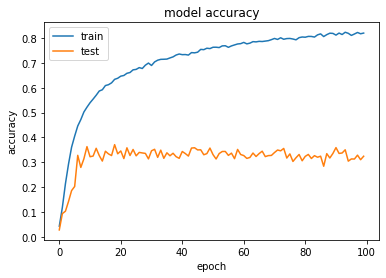

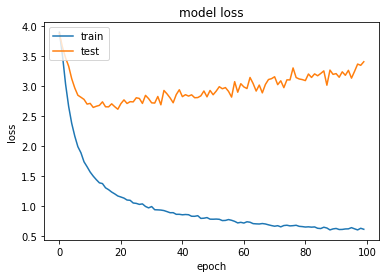

In [31]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

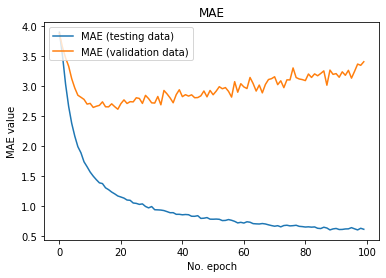

In [32]:
# Plot history: MAE
plt.plot(history.history['loss'], label='MAE (testing data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

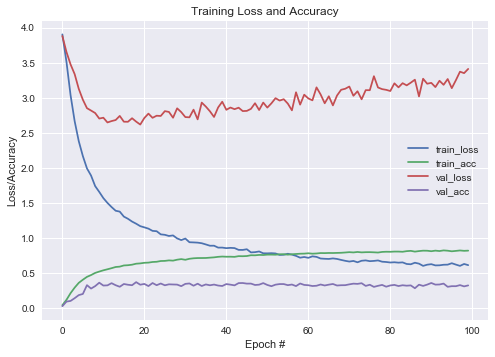

In [33]:
import matplotlib.pyplot as plt

N = np.arange(0, len(history.history['loss']))

# You can chose the style of your preference
# print(plt.style.available) to see the available options
plt.style.use("seaborn")

# Plot train loss, train acc, val loss and val acc against epochs passed
plt.figure()
plt.plot(N, history.history['loss'], label = "train_loss")
plt.plot(N, history.history['accuracy'], label = "train_acc")
plt.plot(N, history.history['val_loss'], label = "val_loss")
plt.plot(N, history.history['val_accuracy'], label = "val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
# Make sure there exists a folder called output in the current directory
# or replace 'output' with whatever direcory you want to put in the plots
plt.show()
plt.savefig('../Output/EpochInceptionV3.png')
plt.close()